In [2]:
! pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np

In [61]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset
df = pd.read_csv("final_model_dataset_with_features.csv")

# Define target and features
y = df["cases"]
X = df.drop(columns=["cases"])

# Categorical encoding
categorical_features = ["state"]
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])
xgb_pipeline.fit(X_train, y_train)

# Add predictions to the original DataFrame
df["rf_pred"] = rf_pipeline.predict(X)
df["xgb_pred"] = xgb_pipeline.predict(X)

# Aggregate predictions by state-year
agg = df.groupby(["state", "year"]).agg({
    "cases": "sum",
    "rf_pred": "sum",
    "xgb_pred": "sum"
}).reset_index()

# Evaluate model performance
print(" Evaluation by State-Year Aggregates:")
for model in ["rf_pred", "xgb_pred"]:
    print(f"\n {model.upper()} Metrics:")
    print("MAE :", mean_absolute_error(agg["cases"], agg[model]))
    print("RMSE:", np.sqrt(mean_squared_error(agg["cases"], agg[model])))
    print("R²  :", r2_score(agg["cases"], agg[model]))


 Evaluation by State-Year Aggregates:

 RF_PRED Metrics:
MAE : 3.4650482315112545
RMSE: 12.598104269679252
R²  : 0.8742405905612416

 XGB_PRED Metrics:
MAE : 3.505842076297071
RMSE: 11.879659609275608
R²  : 0.8881752113576196


**This code evaluates Random Forest and XGBoost models by predicting disease cases using all available features except the target variable cases. The models are built using pipelines that include a ColumnTransformer for one-hot encoding the categorical state variable while leaving other variables untouched. After fitting the models, predictions are added to the original dataset. To make the evaluation more meaningful and interpretable across the U.S., predictions and actual case counts are aggregated by state and year. The performance of each model is then measured using three standard regression metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the R-squared (R²) score. This approach allows for fair model comparison based on state-level yearly totals rather than raw instance-level predictions.**

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


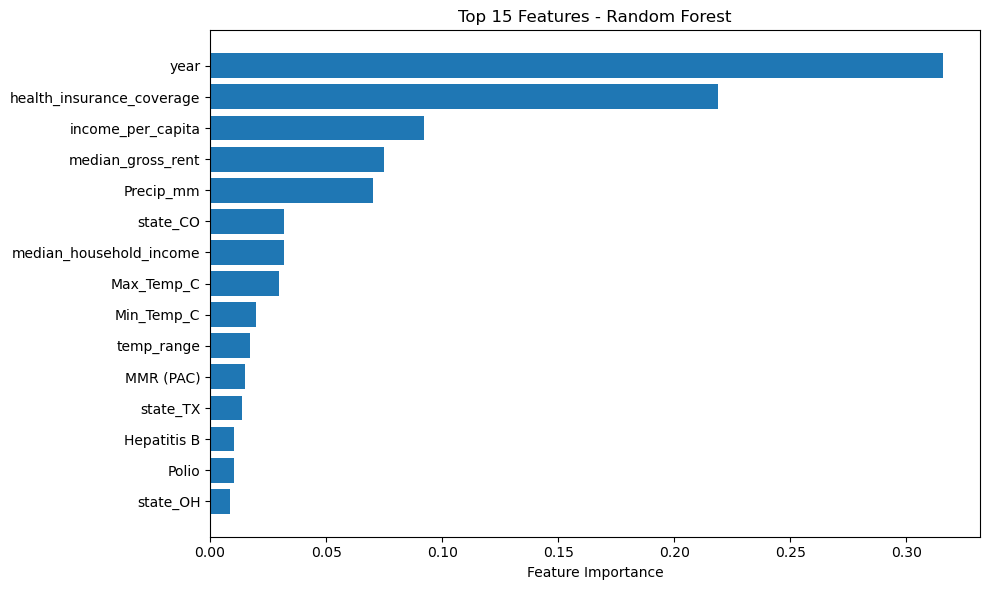

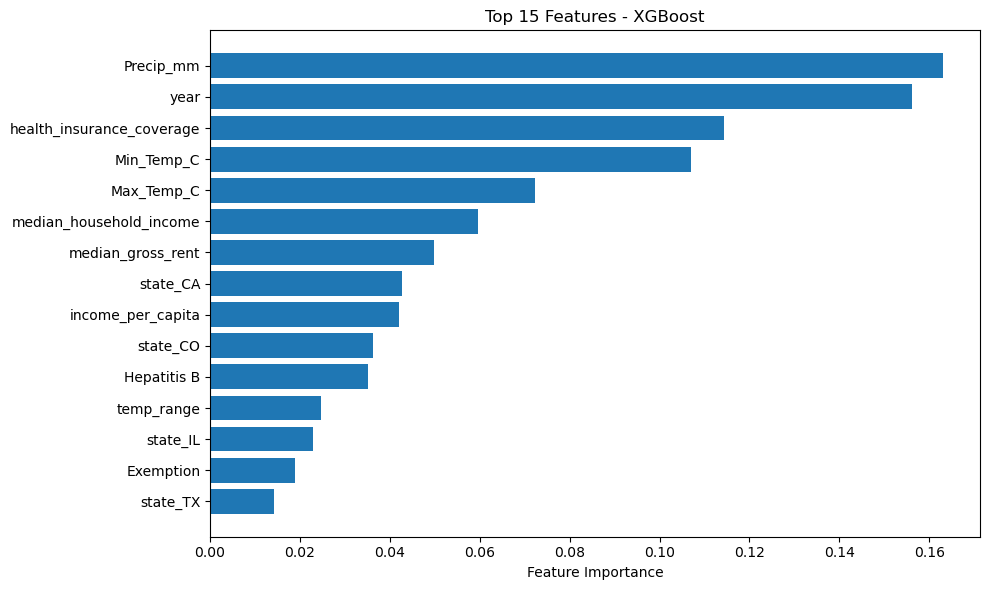

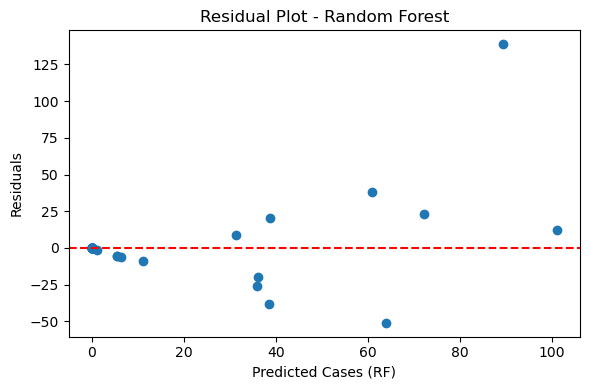

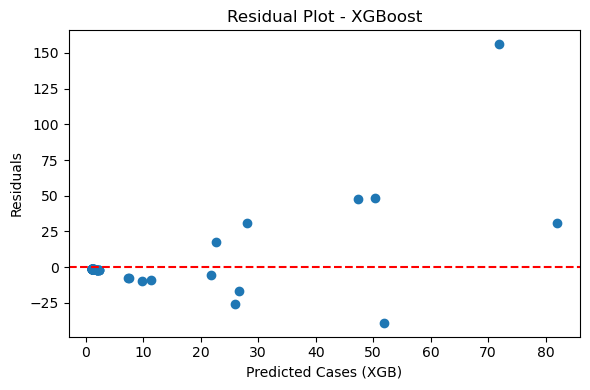

In [64]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
# ---------------------------
# GridSearchCV for both models
# ---------------------------
# Fast Grid for XGBoost
xgb_param_grid = {
    'regressor__n_estimators': [20],
    'regressor__max_depth': [2, 3],
    'regressor__learning_rate': [0.1]
}

# Small grid for Random Forest
rf_param_grid = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': [None, 10]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
xgb_grid.fit(X_train, y_train)

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
rf_grid.fit(X_train, y_train)

# ---------------------------
# Feature Importance
# ---------------------------
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['state'])
numeric_features = X.drop(columns=['state']).columns
all_feature_names = np.concatenate([encoded_feature_names, numeric_features])

# Random Forest
rf_best_model = rf_grid.best_estimator_.named_steps['regressor']
rf_importances = rf_best_model.feature_importances_
rf_sorted_idx = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(all_feature_names[rf_sorted_idx][:15][::-1], rf_importances[rf_sorted_idx][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features - Random Forest")
plt.tight_layout()
plt.show()

# XGBoost
xgb_best_model = xgb_grid.best_estimator_.named_steps['regressor']
xgb_importances = xgb_best_model.feature_importances_
xgb_sorted_idx = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(all_feature_names[xgb_sorted_idx][:15][::-1], xgb_importances[xgb_sorted_idx][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features - XGBoost")
plt.tight_layout()
plt.show()

# ---------------------------
# Residual Analysis
# ---------------------------
rf_preds = rf_grid.predict(X_test)
xgb_preds = xgb_grid.predict(X_test)

rf_residuals = y_test - rf_preds
xgb_residuals = y_test - xgb_preds

# Random Forest Residuals
plt.figure(figsize=(6, 4))
plt.scatter(rf_preds, rf_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Cases (RF)")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.tight_layout()
plt.show()

# XGBoost Residuals
plt.figure(figsize=(6, 4))
plt.scatter(xgb_preds, xgb_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Cases (XGB)")
plt.ylabel("Residuals")
plt.title("Residual Plot - XGBoost")
plt.tight_layout()
plt.show()

**This section focuses on tuning and interpreting the performance of the Random Forest and XGBoost models. Using GridSearchCV, small hyperparameter grids were tested to find the best-performing configurations for each model based on cross-validation. After identifying the best estimators, feature importance was extracted and visualized for both models, revealing which input variables most strongly influenced disease case predictions. Random Forest and XGBoost both highlighted the most relevant predictors among state encodings and numeric variables. Finally, residual plots were created to assess the quality of predictions—plots of predicted values versus residuals help diagnose model bias and variance. Ideally, residuals should be randomly scattered around zero, indicating no systematic prediction errors.**

In [63]:
print(agg)  # Shows the first 10 rows


    state  year  cases  rf_pred   xgb_pred
0      AK  2020      0     0.00   0.044576
1      AK  2021      0     0.00   0.044576
2      AK  2022      3    11.02   9.097005
3      AL  2016      0     0.00  -0.002205
4      AL  2017      0     0.00  -0.002205
..    ...   ...    ...      ...        ...
306    WV  2020      0     0.00  -0.235056
307    WV  2021      0     0.00  -0.235056
308    WV  2022     16    36.02  24.540573
309    WY  2021      0     0.00   0.688178
310    WY  2022      2     4.93  15.115134

[311 rows x 5 columns]


**The agg DataFrame summarizes disease case predictions generated by both the Random Forest (rf_pred) and XGBoost (xgb_pred) models. For each U.S. state and each year included in the dataset, the actual total number of reported disease cases (cases) is compared against the sum of predicted values from both models. This aggregation allows for a clearer year-to-year and state-by-state evaluation of model performance rather than on individual records, which may contain more noise.**

**By comparing the actual case counts to the predictions, one can visually and statistically assess how closely each model is capturing temporal and geographic trends. For instance, if a model consistently underestimates or overestimates the number of cases for certain states or years, it may indicate either missing predictors or temporal shifts the model is not capturing. This format is particularly useful when evaluating public health forecasting models, as decisions are often made at the state level and across annual timelines. Further analysis, such as plotting the predictions versus actual cases, would help in identifying specific trends, biases, or systematic errors in the models.**

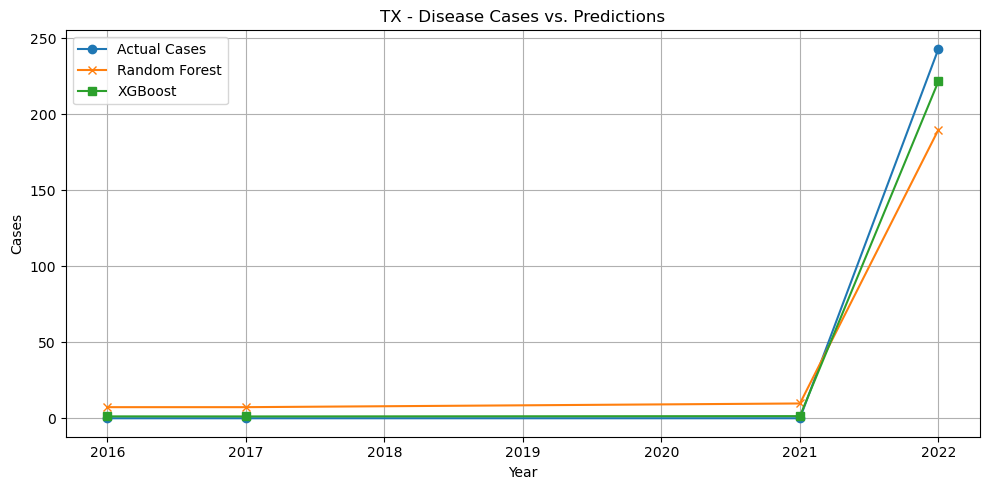

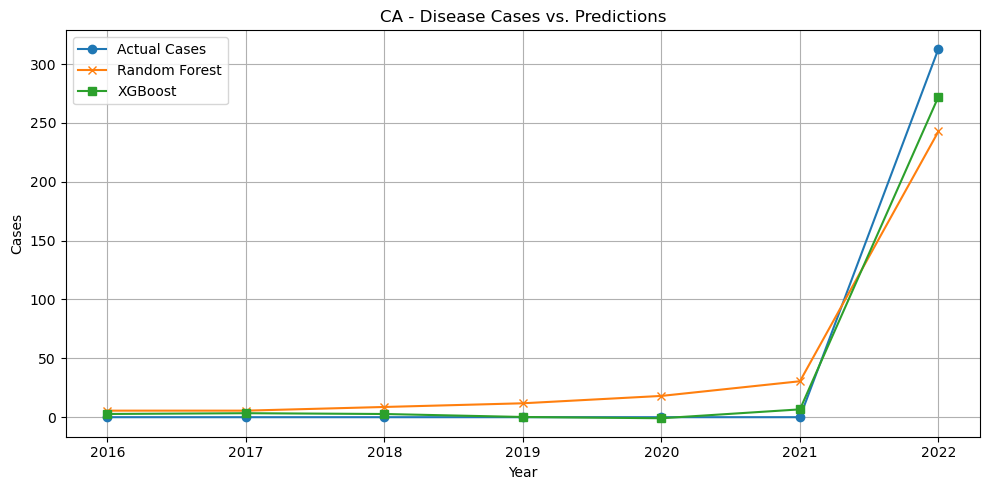

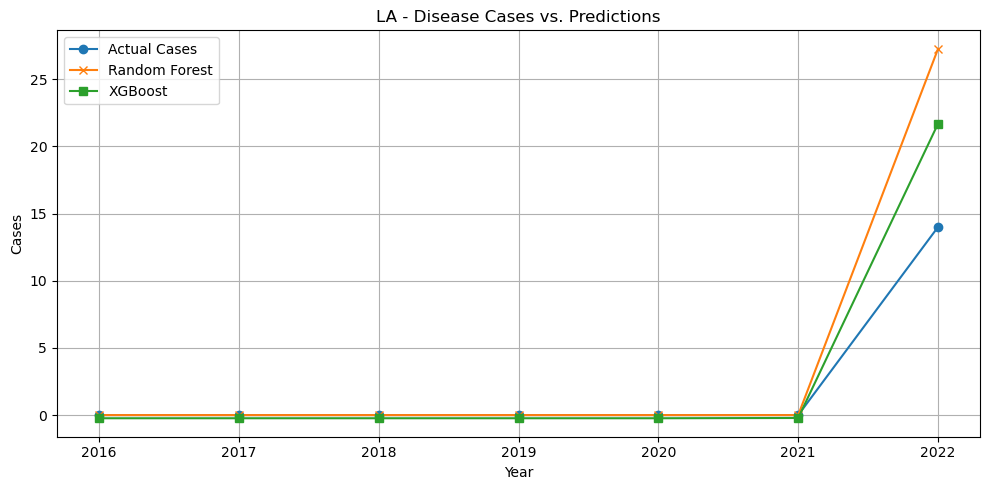

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


# Choose a few states to plot
states_to_plot = ["TX", "CA", "LA"]

# Generate comparison plots
for state in states_to_plot:
    state_data = agg[agg["state"] == state]

    plt.figure(figsize=(10, 5))
    plt.plot(state_data["year"], state_data["cases"], marker='o', label='Actual Cases')
    plt.plot(state_data["year"], state_data["rf_pred"], marker='x', label='Random Forest')
    plt.plot(state_data["year"], state_data["xgb_pred"], marker='s', label='XGBoost')
    plt.title(f"{state} - Disease Cases vs. Predictions")
    plt.xlabel("Year")
    plt.ylabel("Cases")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**This code snippet creates visual comparisons of actual versus predicted disease cases over time for three selected states: Texas (TX), California (CA), and Louisiana (LA).**

**For each of these states:**

**The actual reported case counts are plotted with circles (marker='o').**

**Random Forest predictions are shown with x-marks.**

**XGBoost predictions are indicated with squares.**

**Each plot helps illustrate how closely each model tracks the true trend in reported cases across years. If the predicted lines closely follow the actual line, the model is doing well. On the other hand, large gaps between the actual and predicted lines may highlight where the model struggles. This kind of visualization is especially helpful in identifying model accuracy and temporal consistency at the state level.**

In [90]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("final_model_dataset_with_features.csv")

# Top 15 important features from your plots
top_features = [
    "year", "health_insurance_coverage", "income_per_capita", "median_gross_rent",
    "Precip_mm", "state", "median_household_income", "Max_Temp_C", "Min_Temp_C",
    "temp_range", "MMR (PAC)", "Hepatitis B", "Polio", "Exemption"
]

# Define target and selected features
y = df["cases"]
X = df[top_features]  # Only keep top features

# Categorical encoding
categorical_features = ["state"]
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])
xgb_pipeline.fit(X_train, y_train)

# Add predictions to the original DataFrame
df["rf_pred"] = rf_pipeline.predict(X)
df["xgb_pred"] = xgb_pipeline.predict(X)

# Aggregate predictions by state-year
agg = df.groupby(["state", "year"]).agg({
    "cases": "sum",
    "rf_pred": "sum",
    "xgb_pred": "sum"
}).reset_index()

# Evaluate model performance
print(" Evaluation by State-Year Aggregates:")
for model in ["rf_pred", "xgb_pred"]:
    print(f"\n {model.upper()} Metrics:")
    print("MAE :", mean_absolute_error(agg["cases"], agg[model]))
    print("RMSE:", np.sqrt(mean_squared_error(agg["cases"], agg[model])))
    print("R²  :", r2_score(agg["cases"], agg[model]))


 Evaluation by State-Year Aggregates:

 RF_PRED Metrics:
MAE : 3.4044372990353695
RMSE: 12.42982514175732
R²  : 0.8775778138554986

 XGB_PRED Metrics:
MAE : 3.133666559365066
RMSE: 11.170715945095305
R²  : 0.9011237221606296


**Fitted a new model using only the 15 features suggested by the gridsearch cv, it improved the model slightly**

Skipped NC due to error: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipped NY due to error: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Average Metrics Across States:
MAE       864.679277
RMSE     1992.597538
R2     -23409.659164
dtype: float64


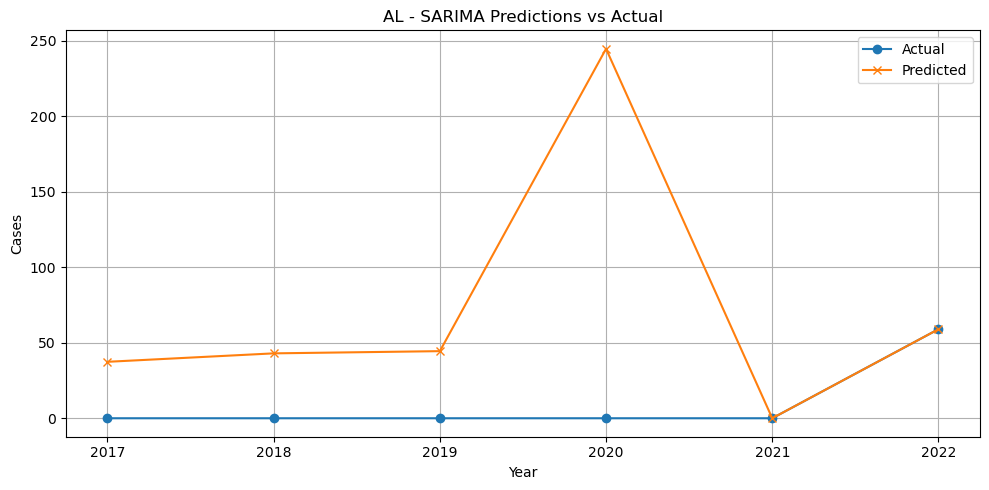

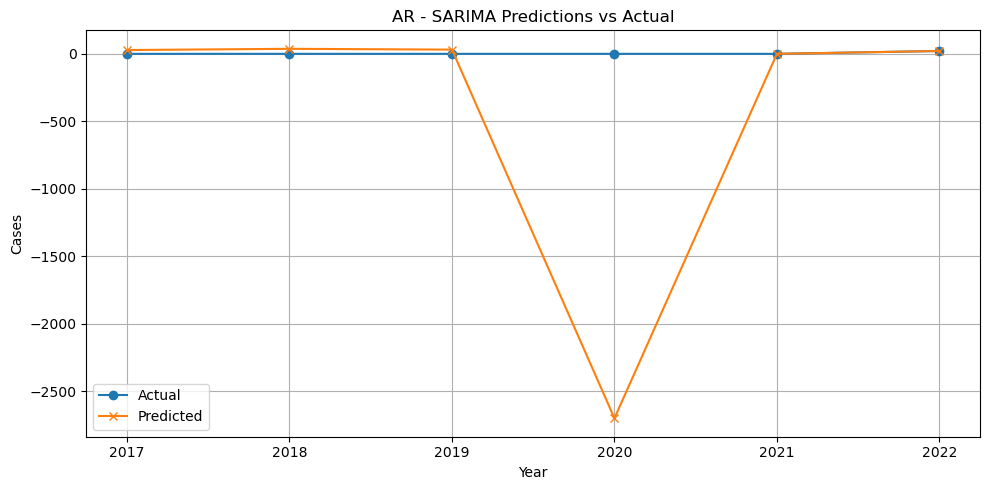

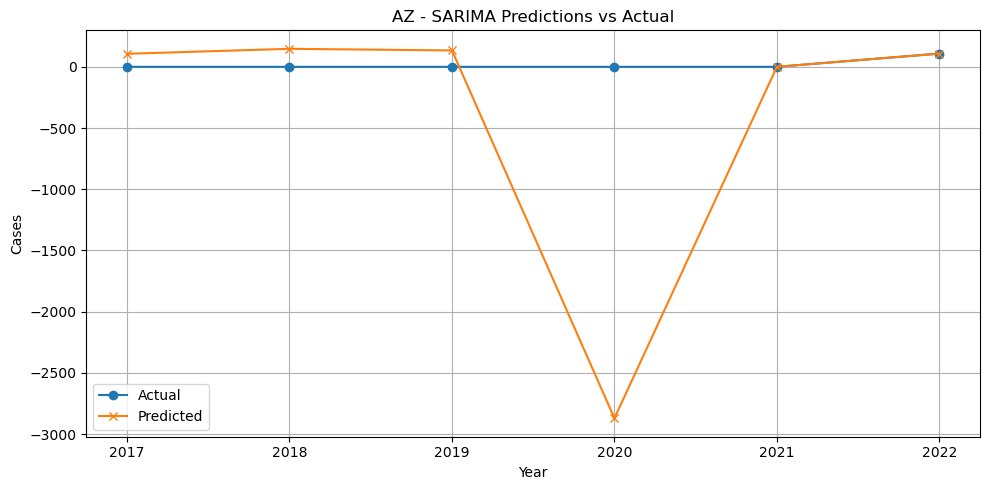

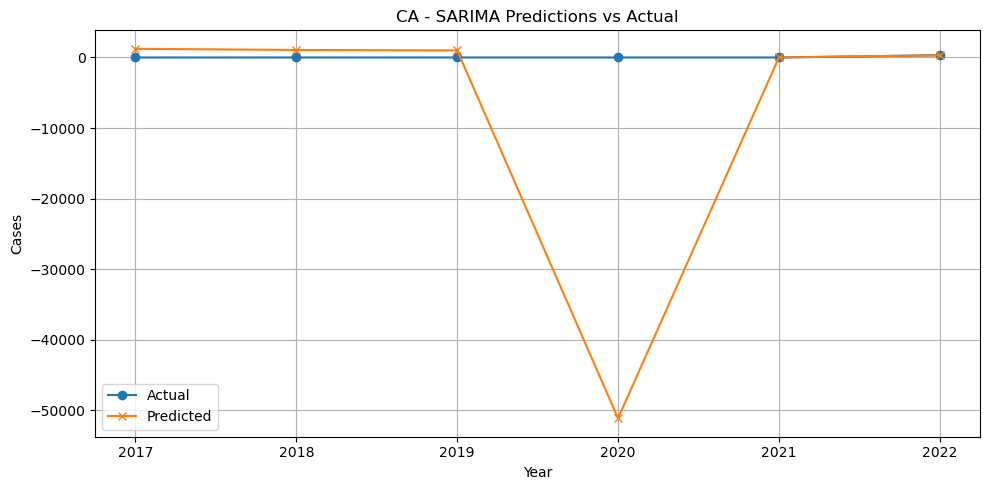

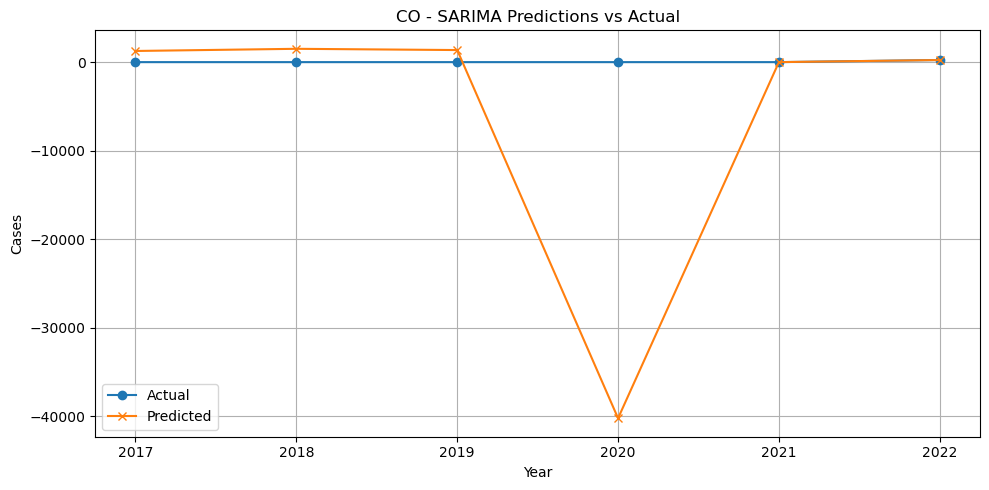

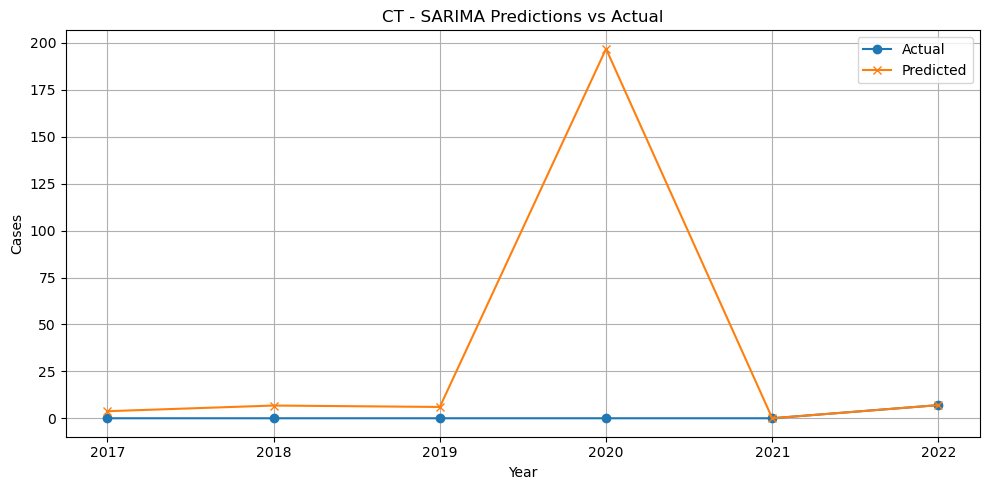

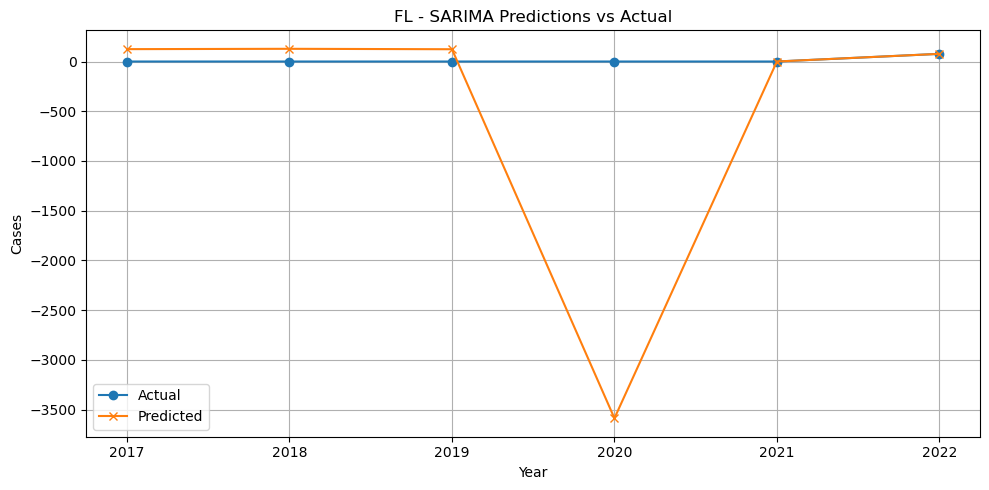

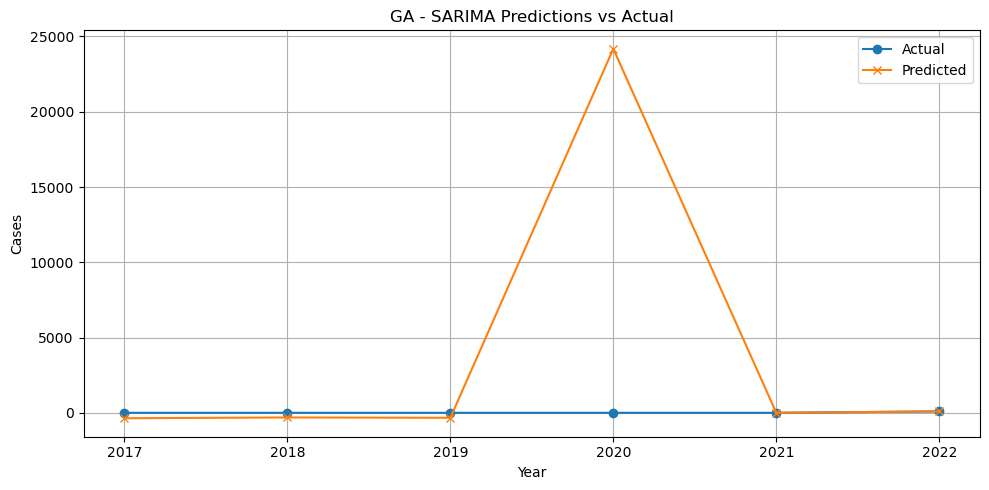

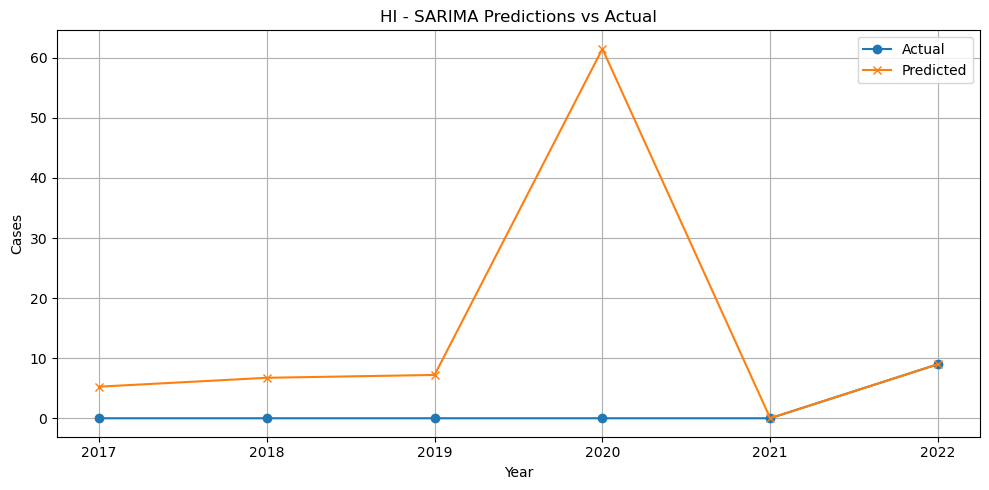

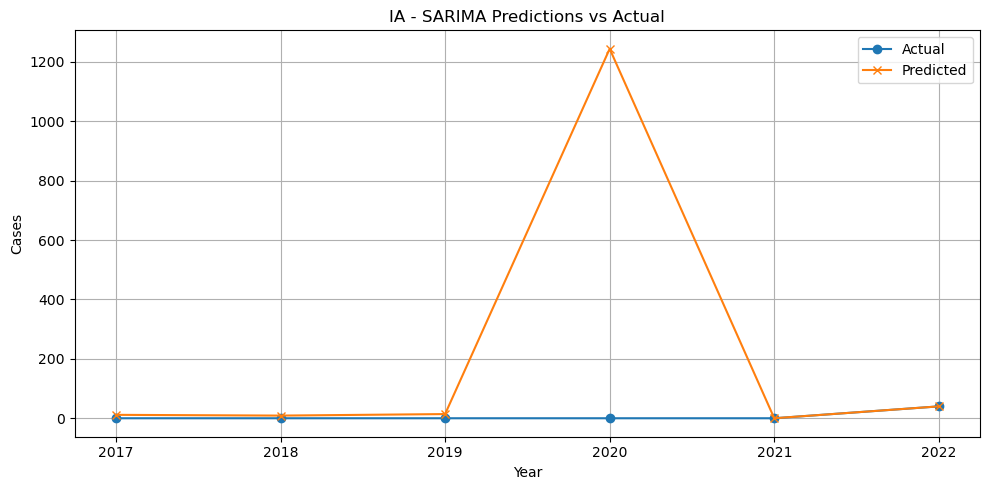

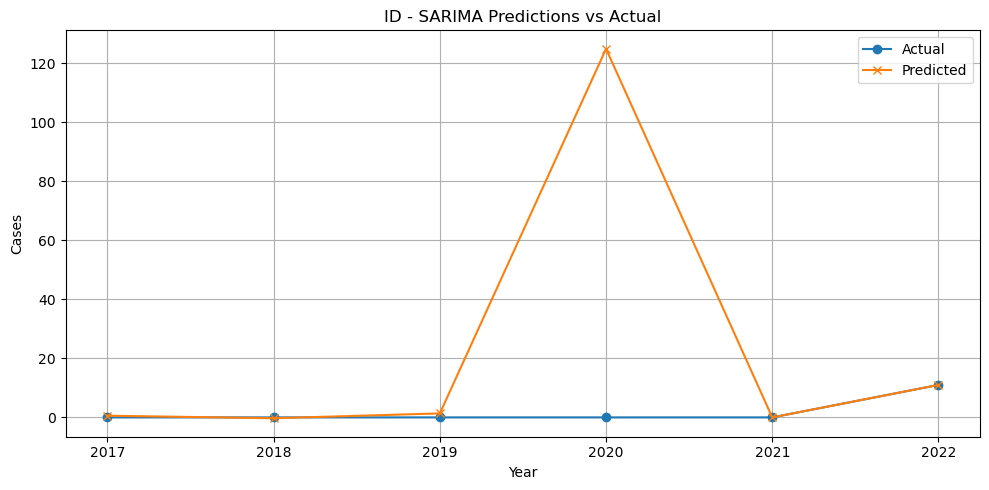

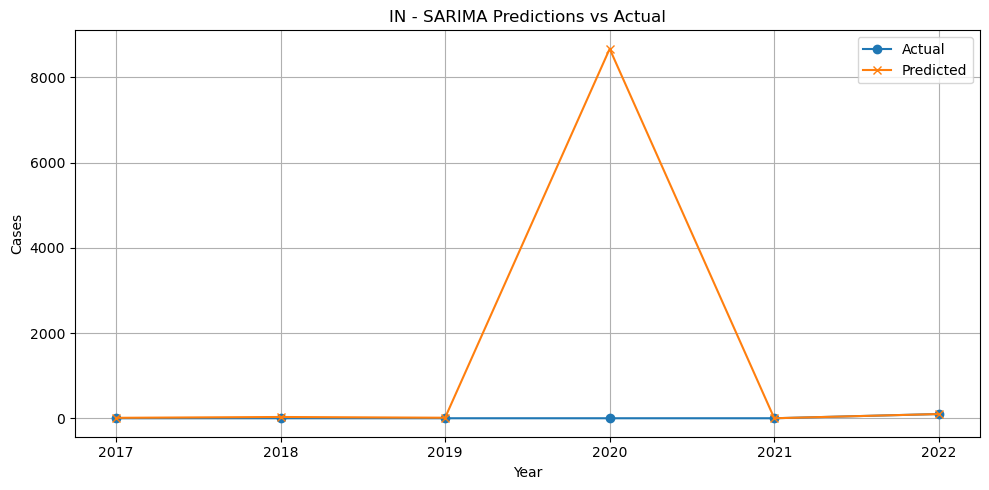

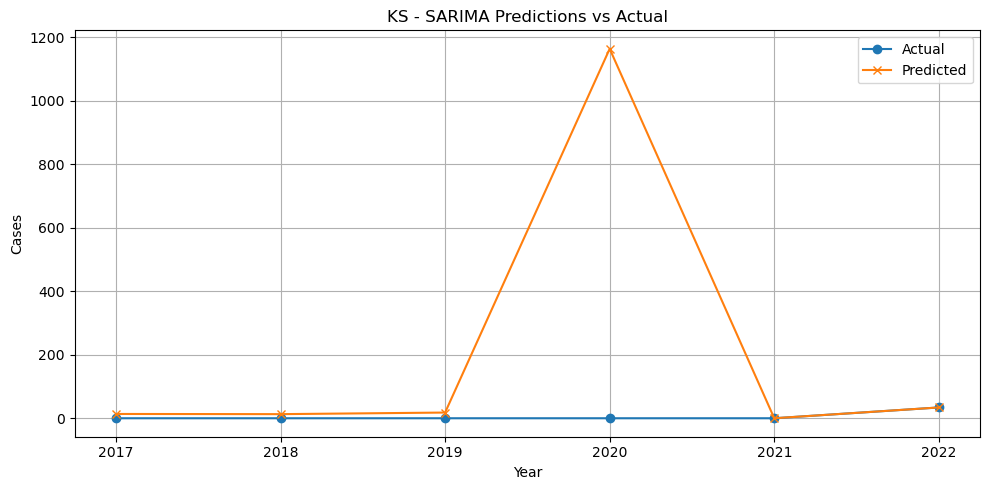

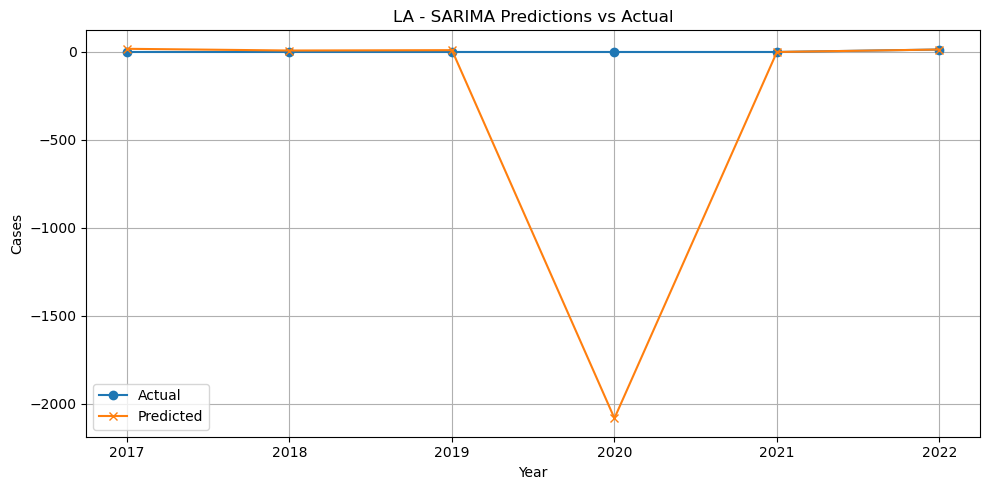

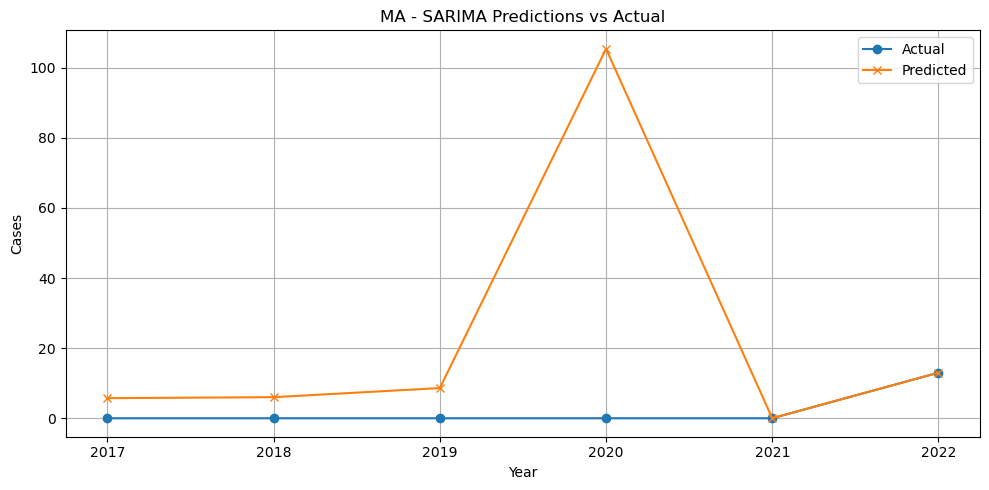

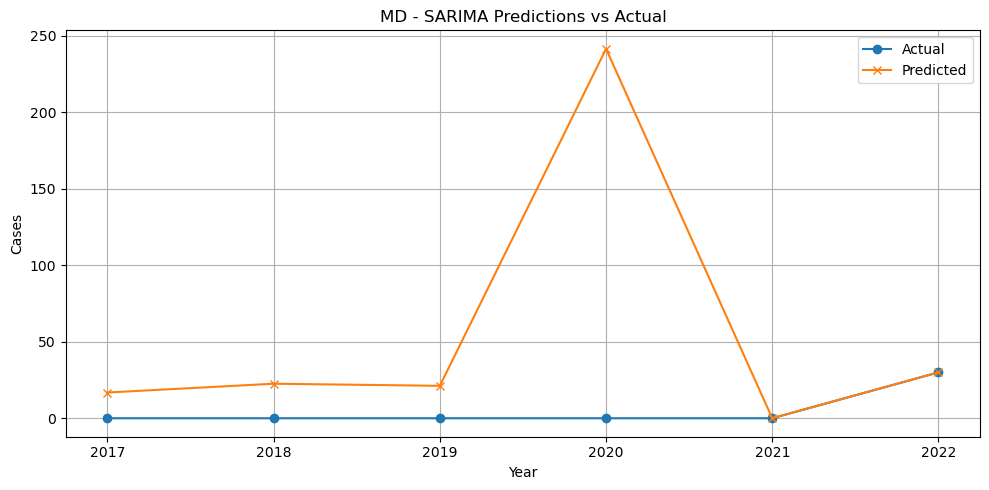

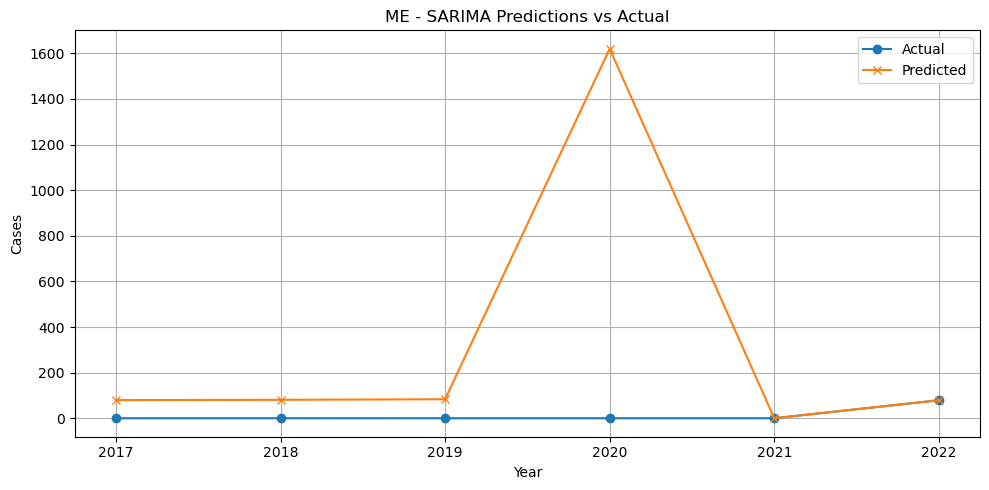

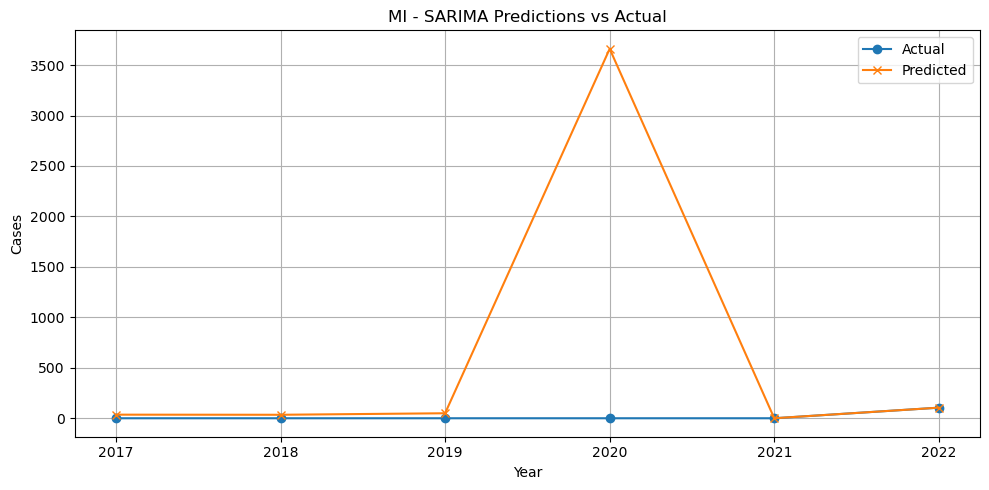

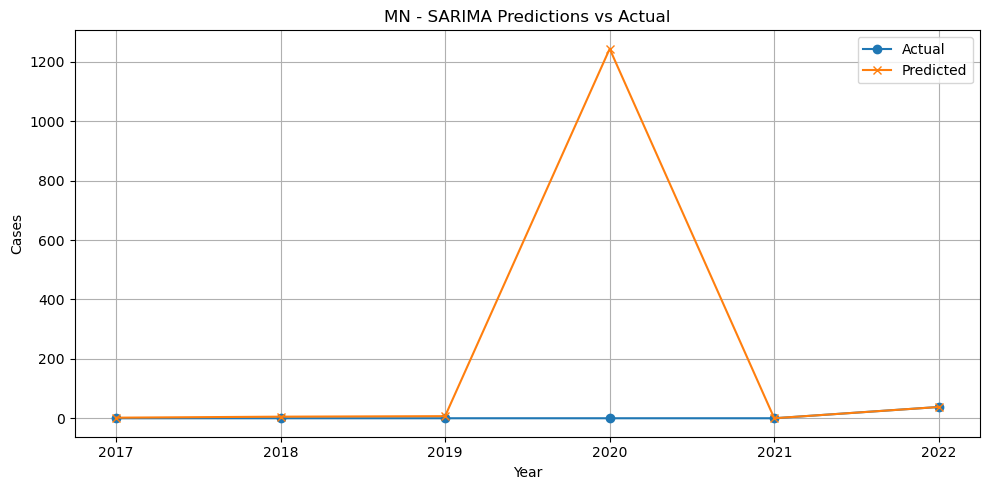

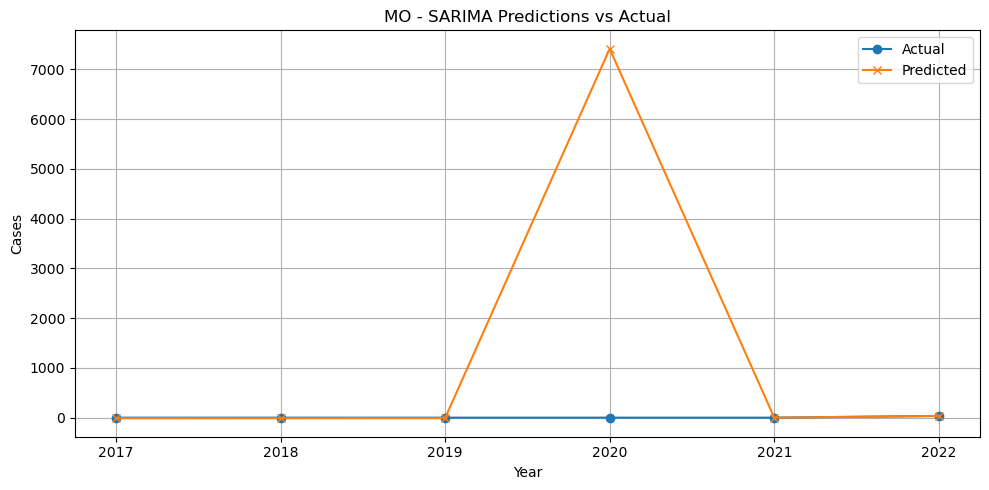

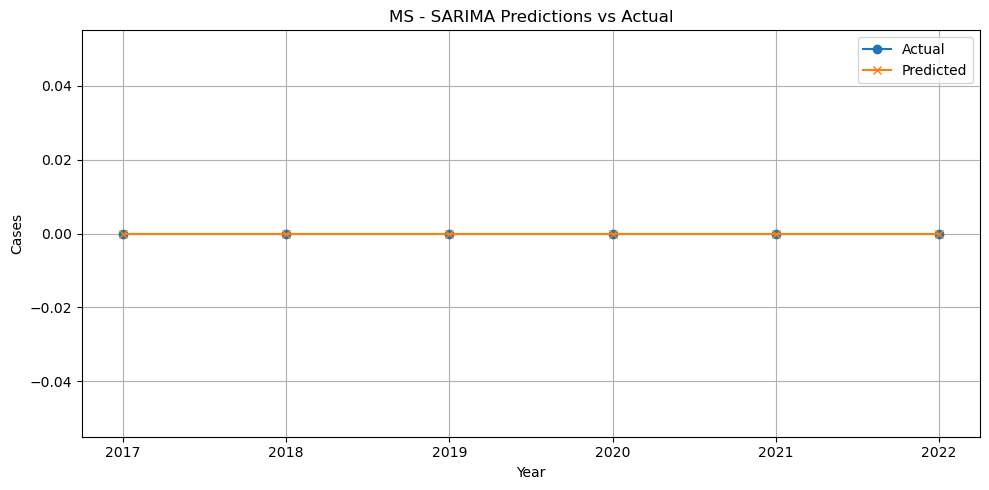

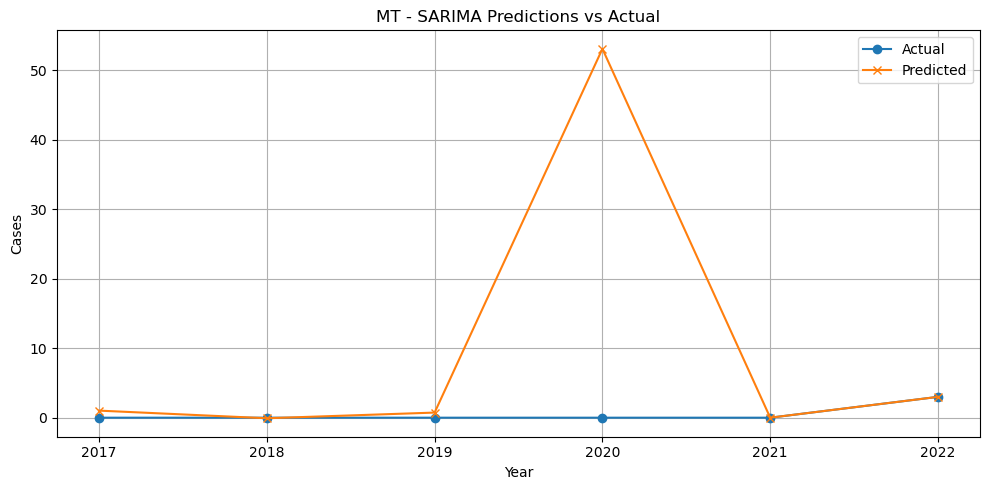

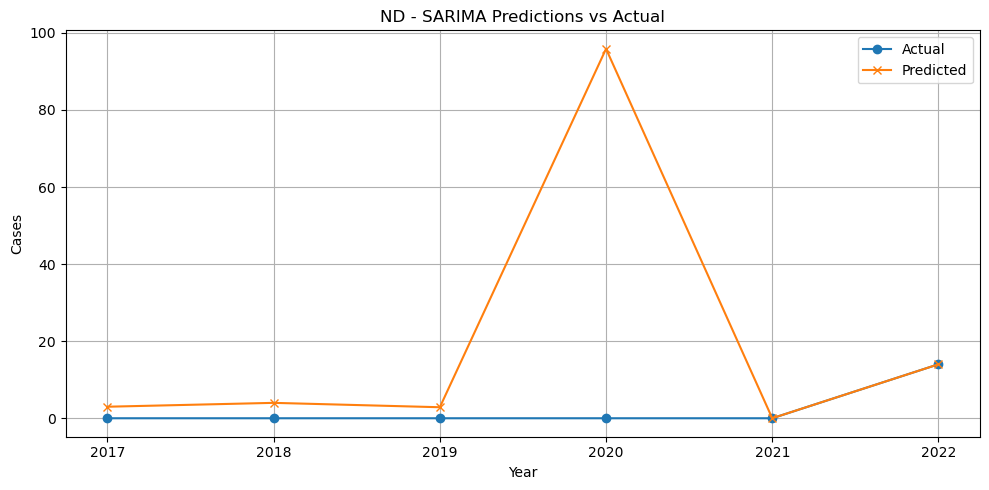

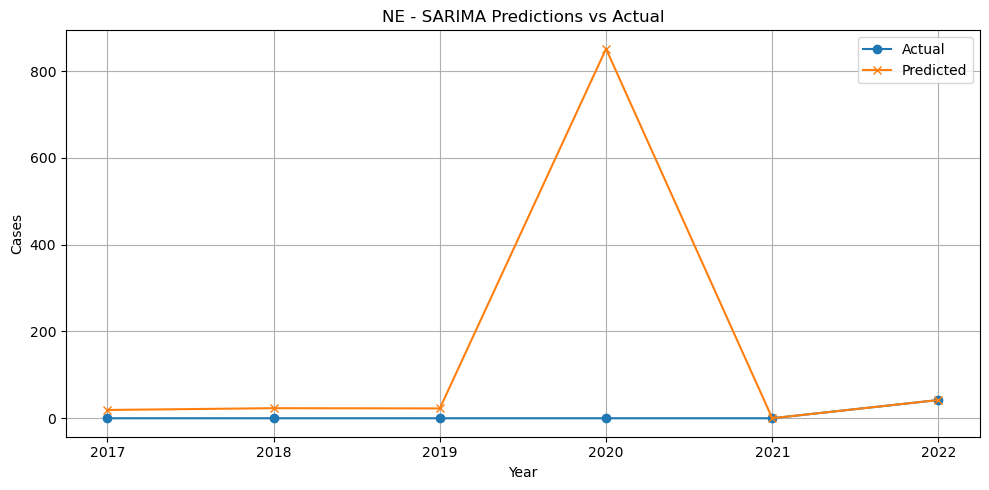

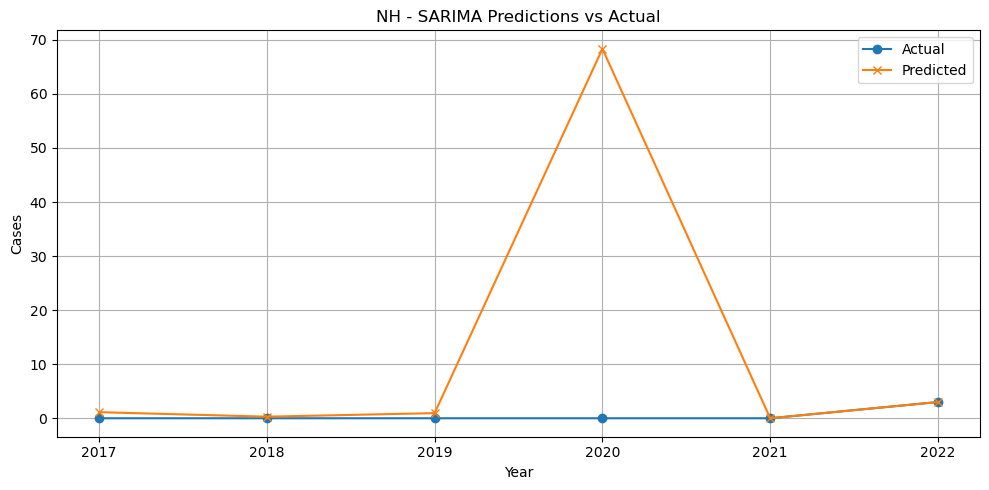

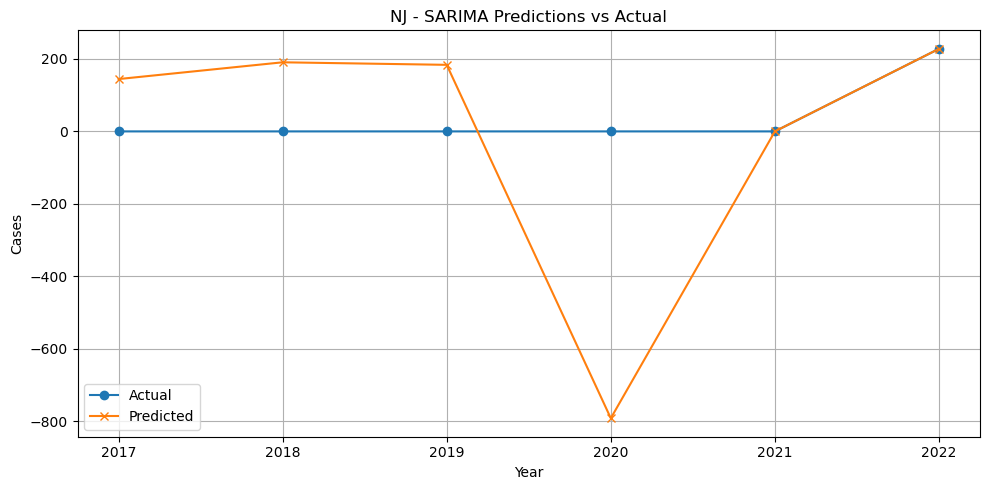

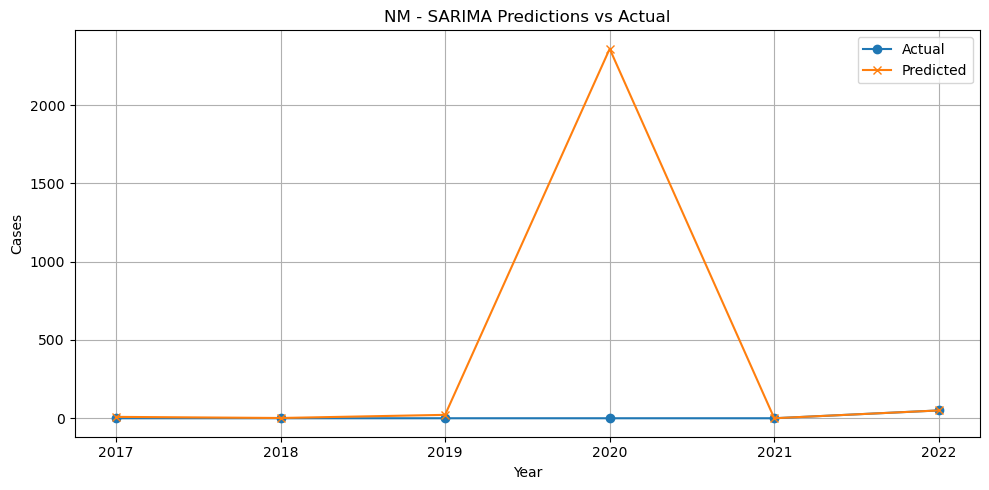

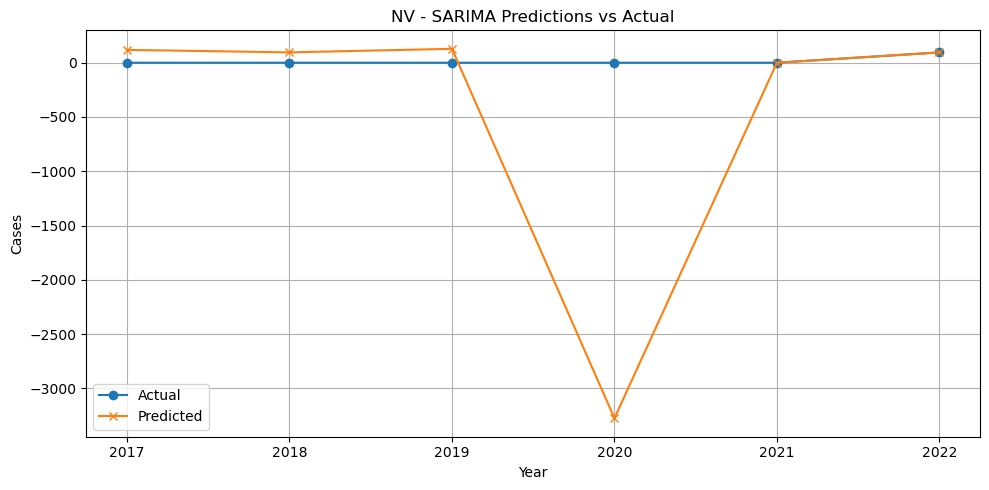

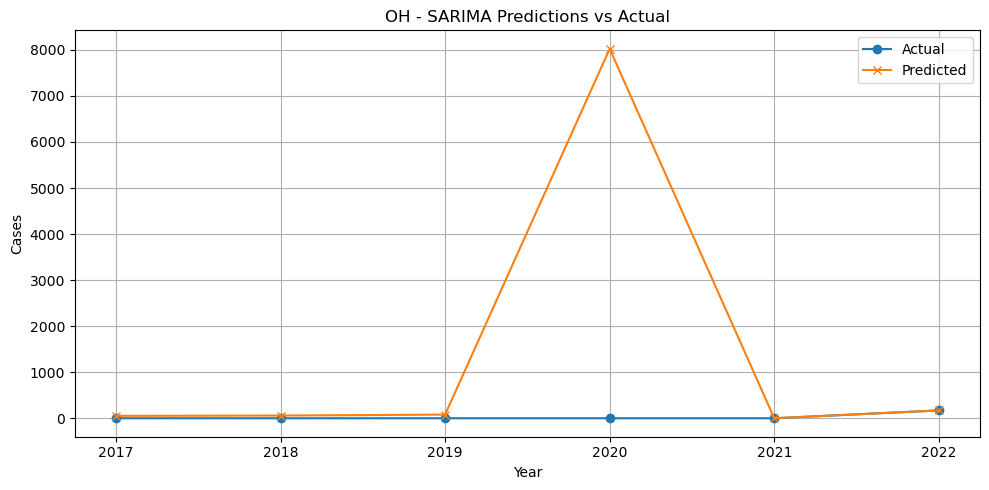

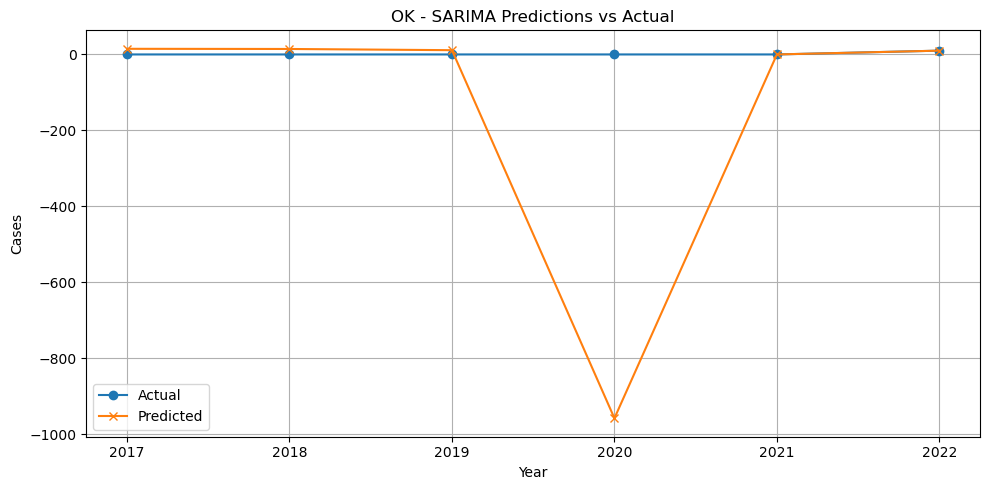

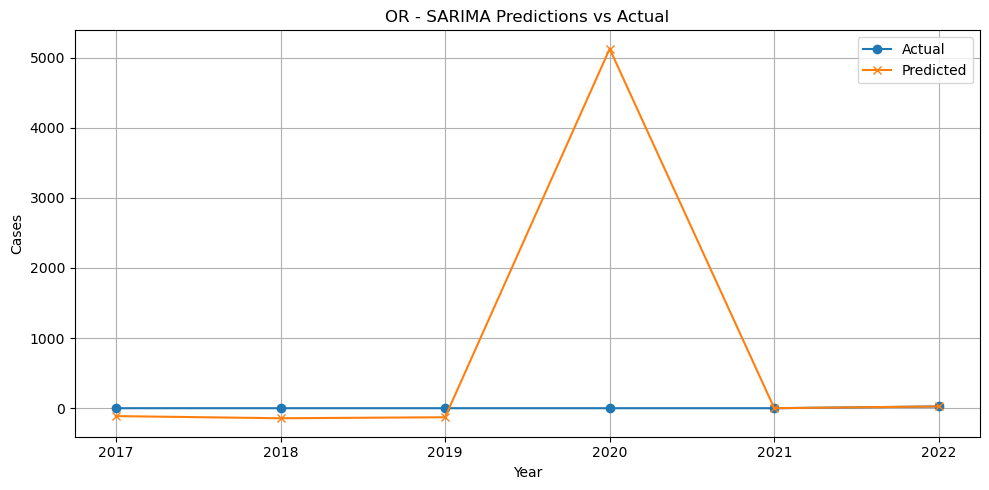

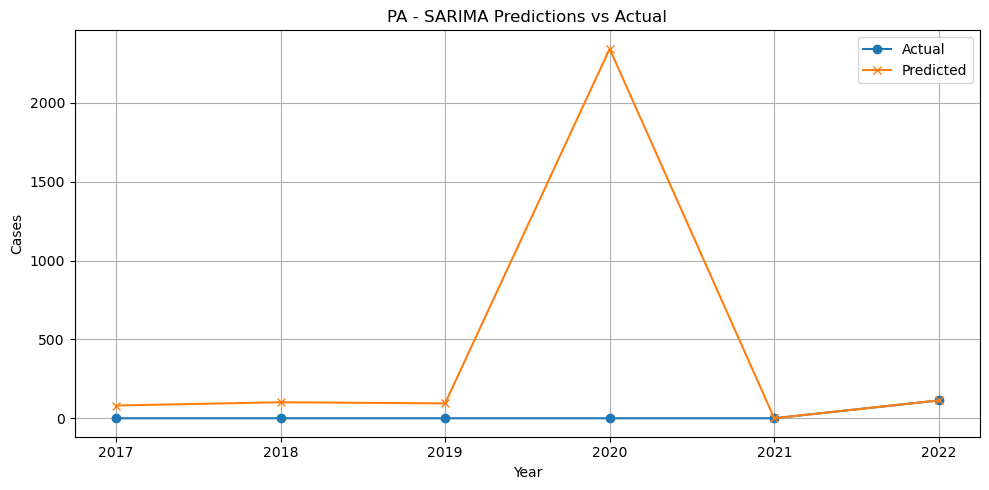

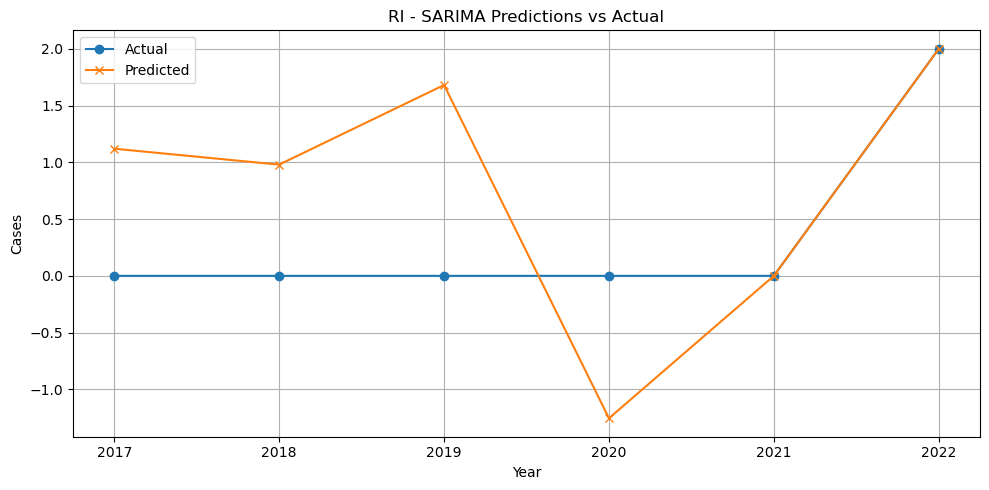

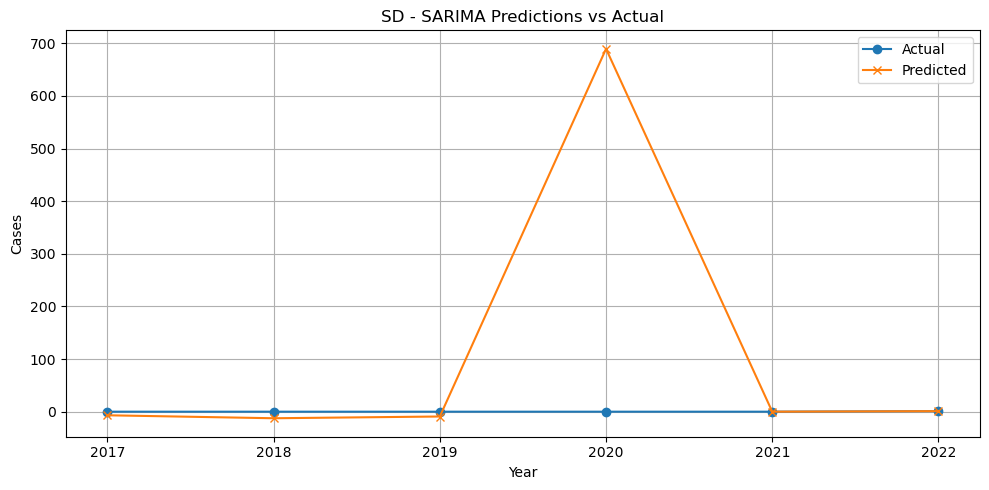

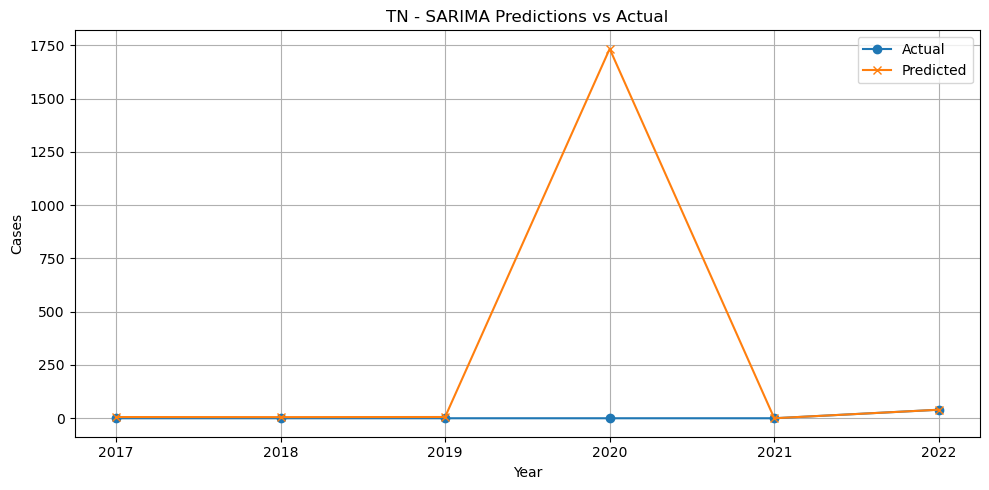

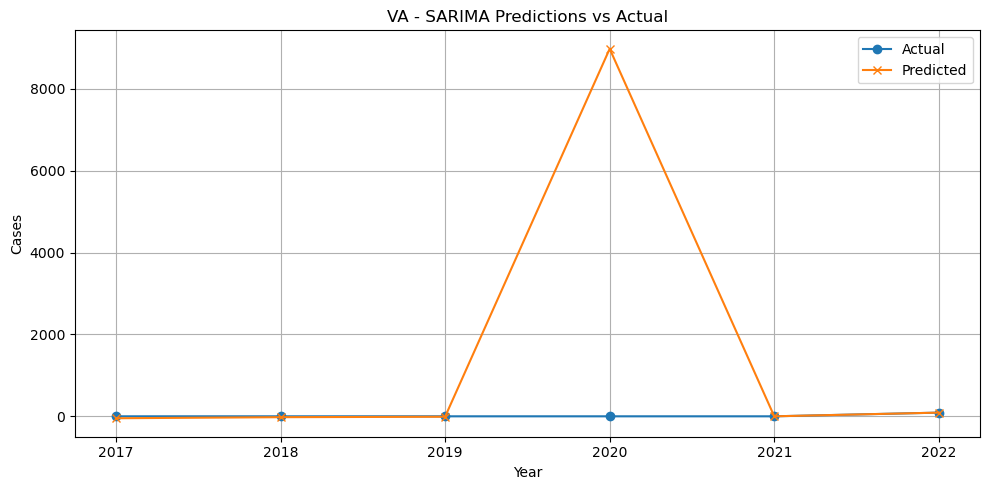

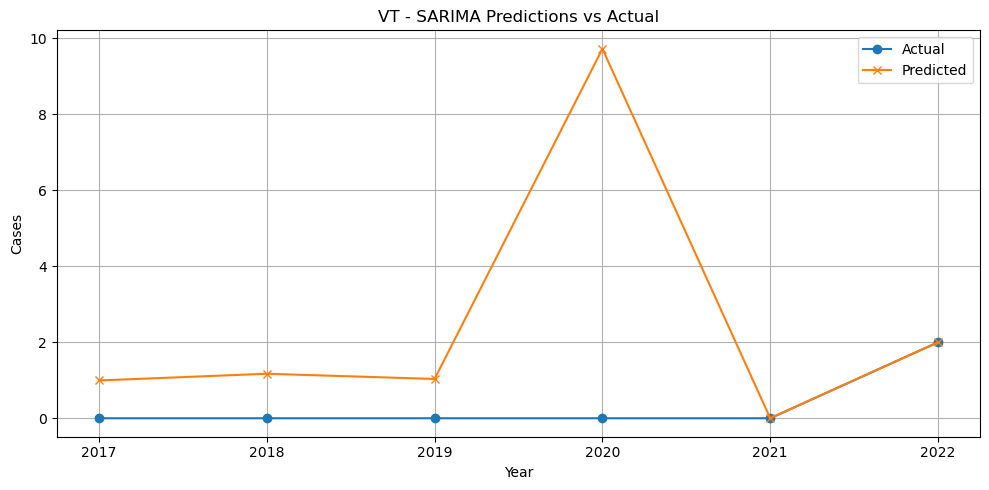

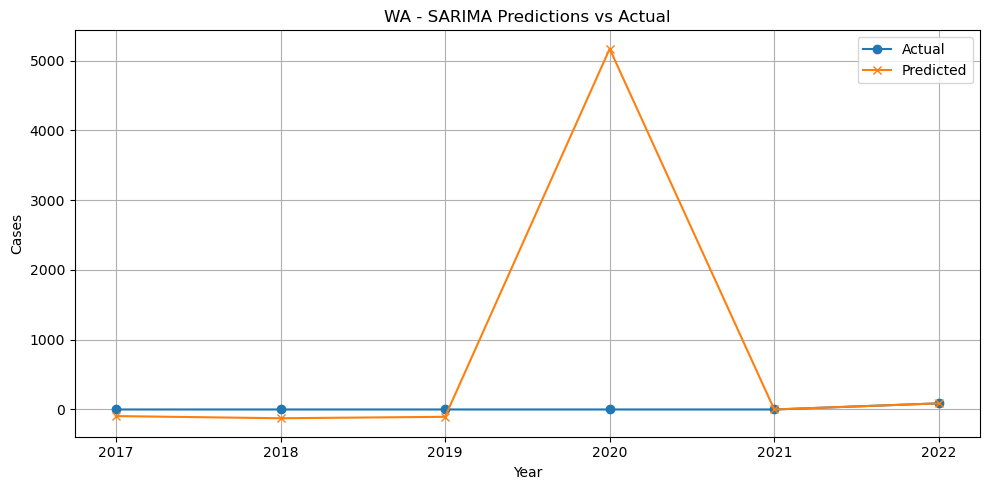

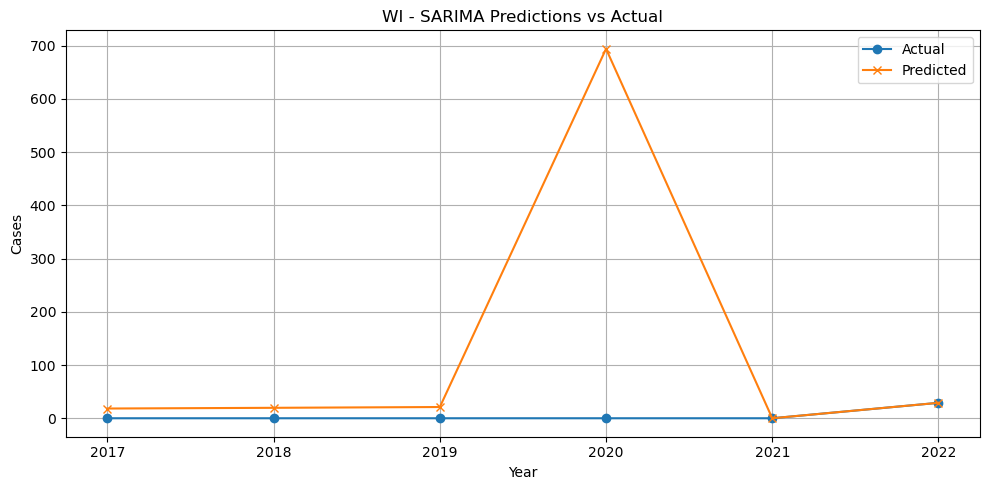

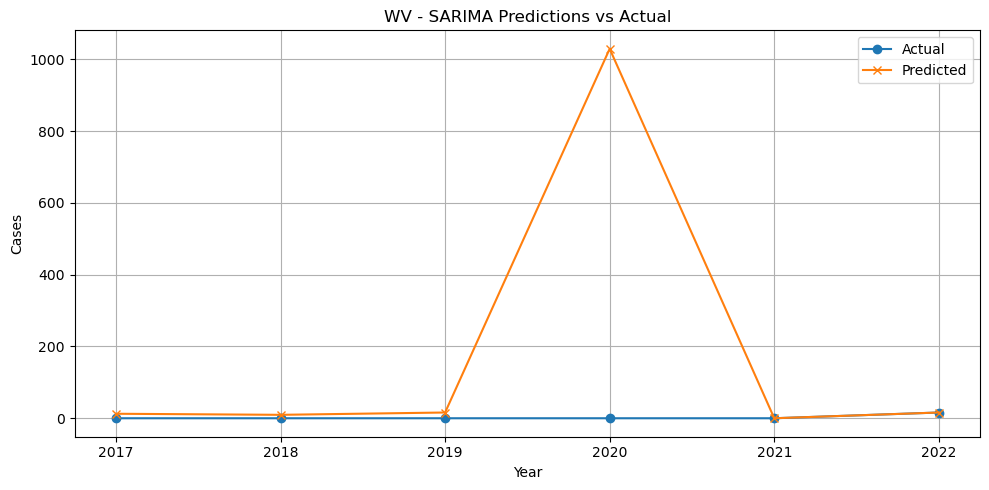

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess dataset
df = pd.read_csv("final_model_dataset_with_features.csv")
df = df.sort_values(["state", "year"])
df = df.dropna(subset=["cases"])  # Drop missing values in target

# Define exogenous variables
exog_vars = df.columns.difference(["cases", "state", "year"])

# Store metrics and predictions
results = []
predictions_plot_data = []

for state in df["state"].unique():
    state_df = df[df["state"] == state].copy()

    if len(state_df) < 5:
        continue  # Skip if not enough data

    try:
        y = state_df["cases"]
        X = state_df[exog_vars]

        # Fit SARIMAX with exogenous variables
        model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4),
                        enforce_stationarity=False, enforce_invertibility=False)
        fitted = model.fit(disp=False)

        # Predict (exclude first row due to differencing)
        preds = fitted.predict(start=1, end=len(y)-1, exog=X.iloc[1:], dynamic=False)
        actual = y.iloc[1:]
        years = state_df["year"].iloc[1:]

        # Store for plotting
        predictions_plot_data.append(pd.DataFrame({
            "state": state,
            "year": years,
            "actual": actual,
            "predicted": preds
        }))

        # Evaluation metrics
        mae = mean_absolute_error(actual, preds)
        rmse = np.sqrt(mean_squared_error(actual, preds))
        r2 = r2_score(actual, preds)

        results.append({
            "state": state,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

    except Exception as e:
        print(f"Skipped {state} due to error: {e}")
        continue

# Create DataFrame for metrics
results_df = pd.DataFrame(results)

# Compute average metrics across all states
average_metrics = results_df[["MAE", "RMSE", "R2"]].mean()
print("Average Metrics Across States:")
print(average_metrics)

# Combine prediction results for plotting
all_preds_df = pd.concat(predictions_plot_data)

# Plot actual vs predicted for each state
for state in all_preds_df["state"].unique():
    state_data = all_preds_df[all_preds_df["state"] == state]
    plt.figure(figsize=(10, 5))
    plt.plot(state_data["year"], state_data["actual"], label="Actual", marker='o')
    plt.plot(state_data["year"], state_data["predicted"], label="Predicted", marker='x')
    plt.title(f"{state} - SARIMA Predictions vs Actual")
    plt.xlabel("Year")
    plt.ylabel("Cases")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**To better understand yearly disease case trends across U.S. states, a SARIMA model with exogenous variables was fitted individually for each state using historical data. The model incorporated both non-seasonal and seasonal components, accounting for possible yearly fluctuations with a seasonal period of 4 (which was assumed for illustrative purposes). Predictors such as climate, vaccination coverage, and socioeconomic indicators were used as external regressors. For each state with sufficient data, the model was trained and then used to generate one-step-ahead predictions, excluding the first observation due to differencing. Evaluation metrics—Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R²—were computed to assess model accuracy. These metrics were stored for each state and then averaged to obtain an overall performance benchmark. This approach allowed for both granular insight into state-level predictions and a high-level summary of how well the SARIMA model performed overall.**

Average Metrics Across States (ARIMA):
MAE     4.237223e-11
RMSE    5.845293e-11
R2      1.000000e+00
dtype: float64


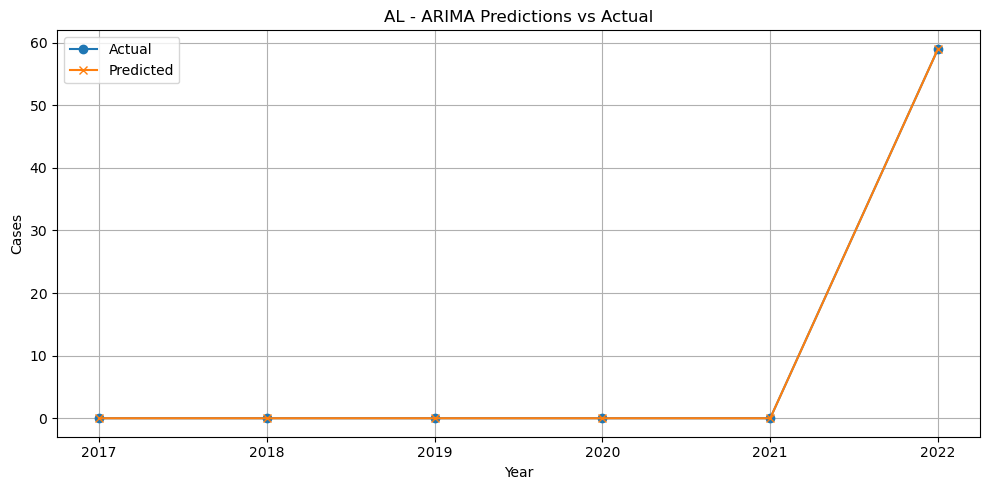

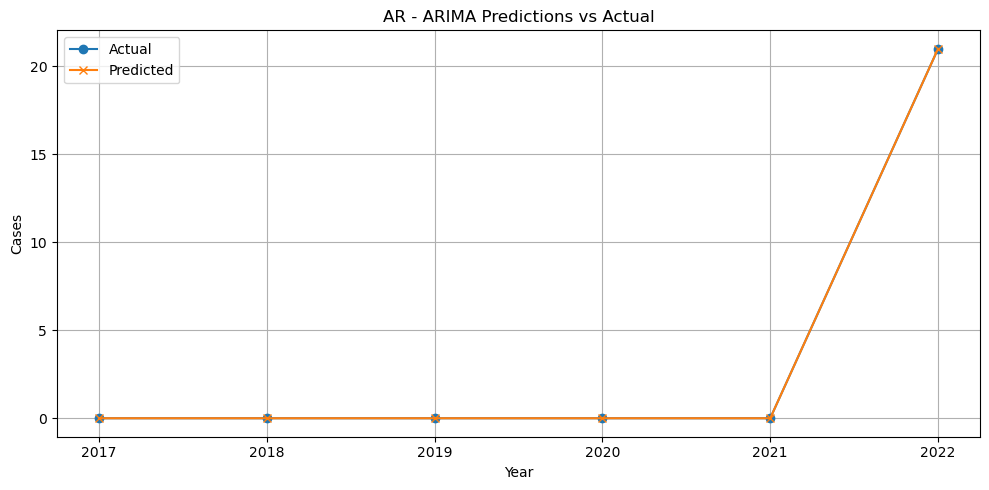

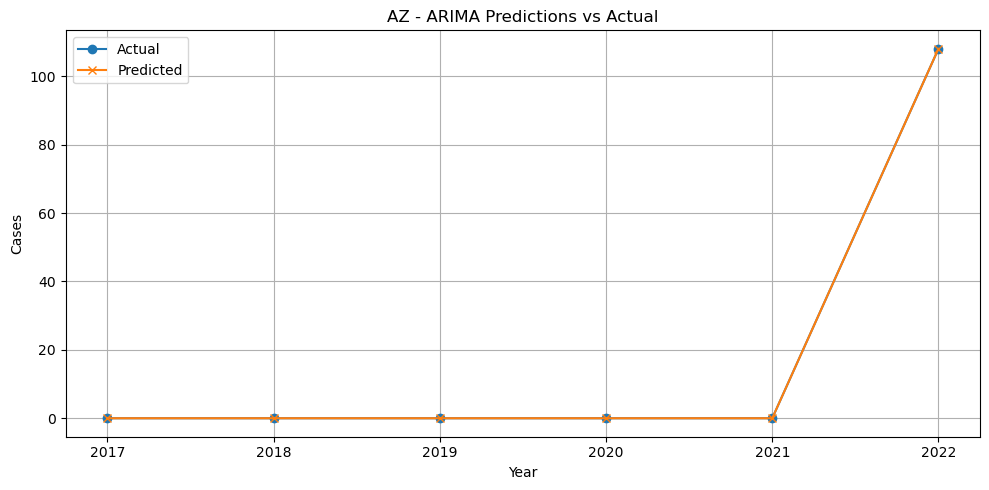

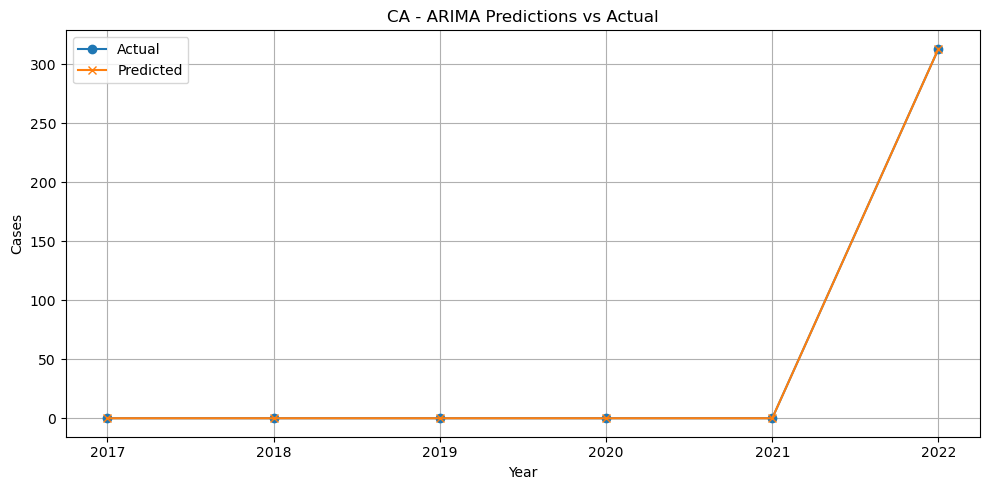

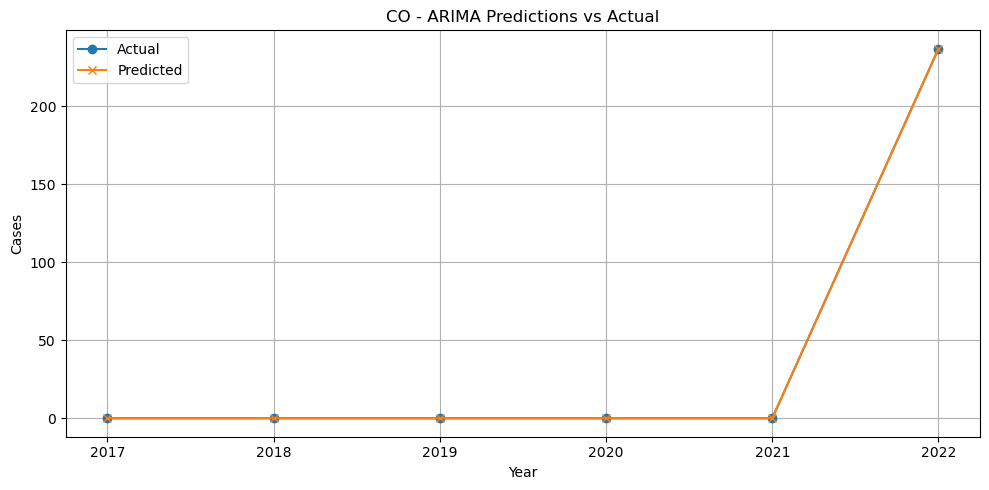

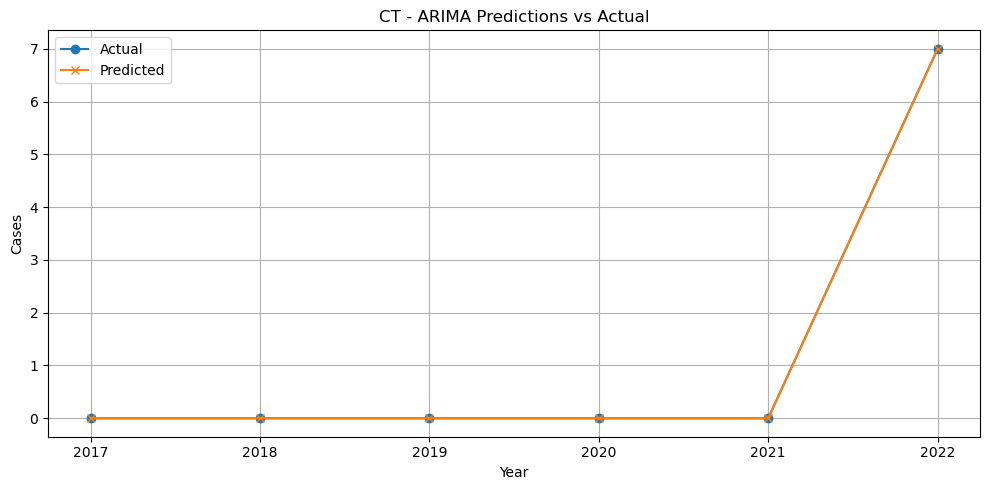

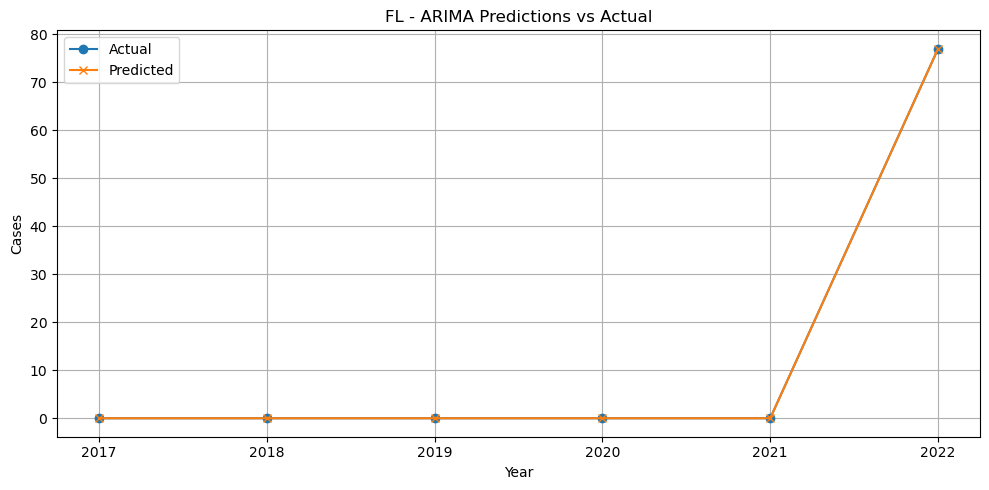

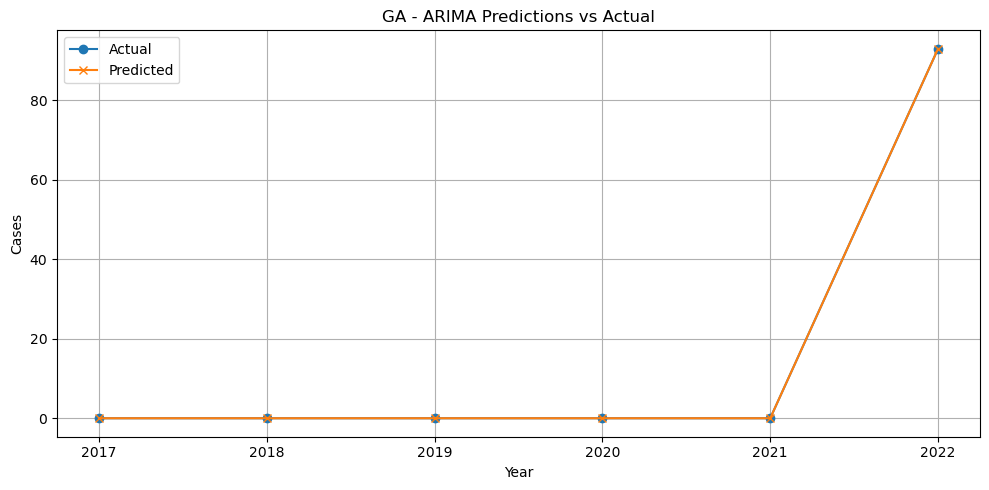

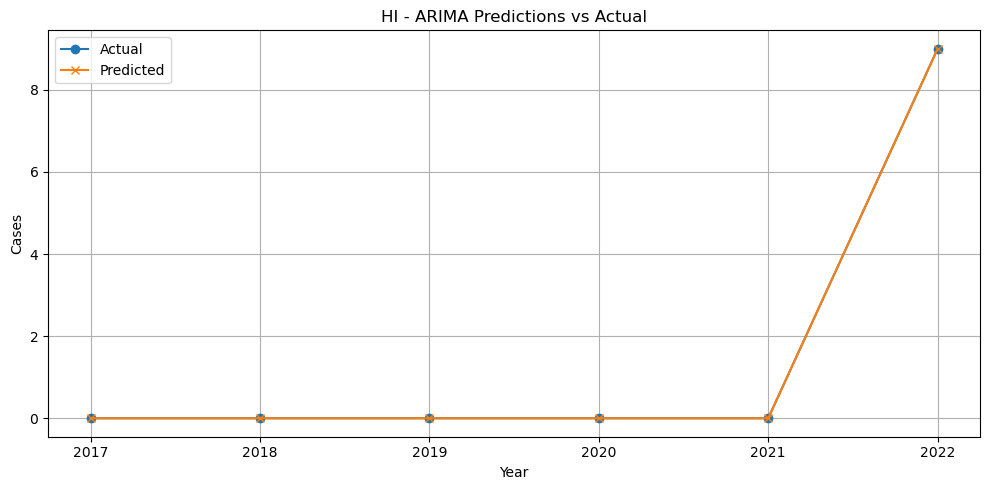

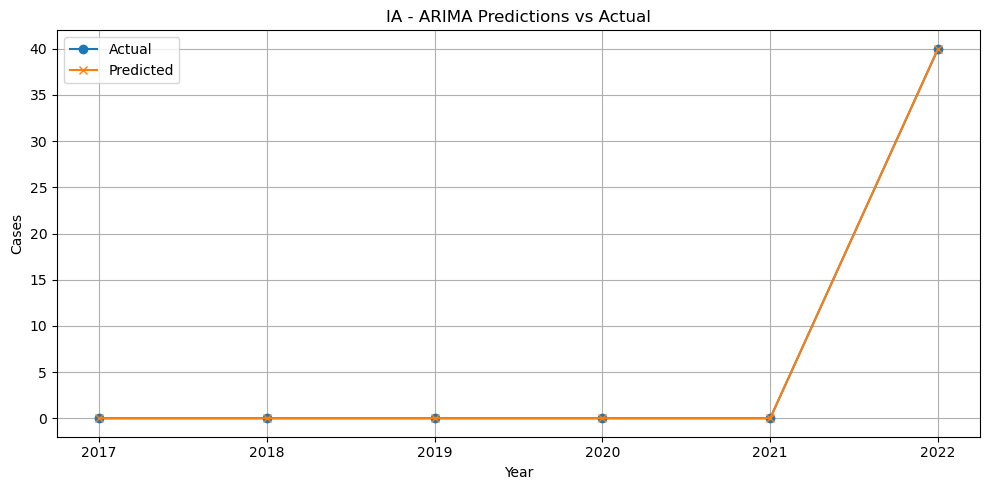

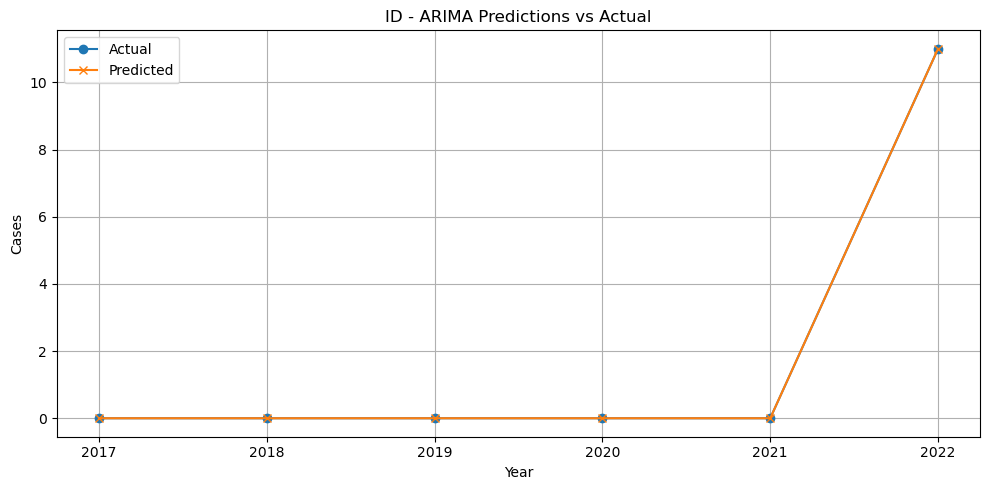

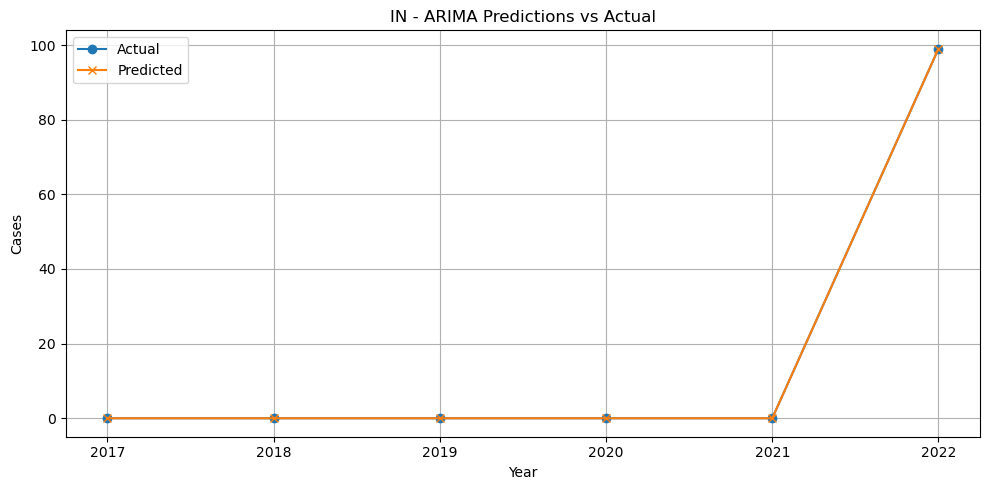

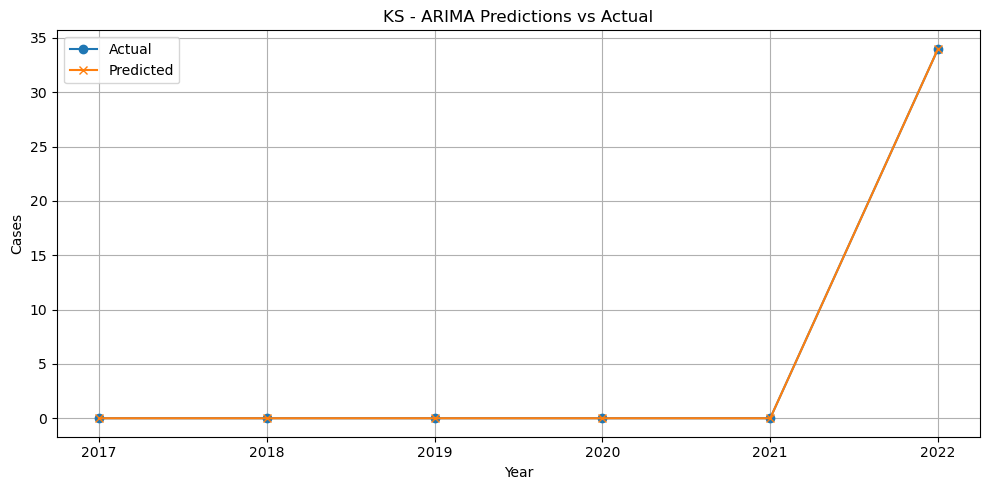

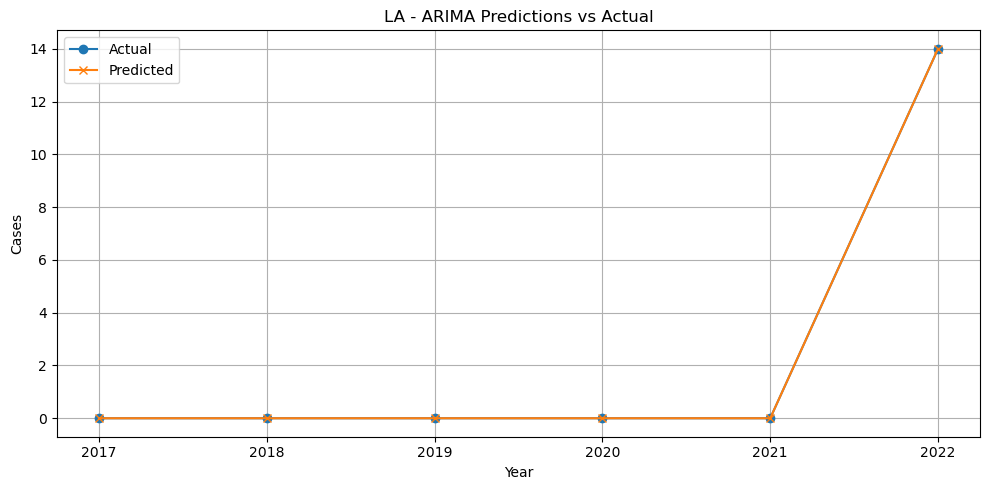

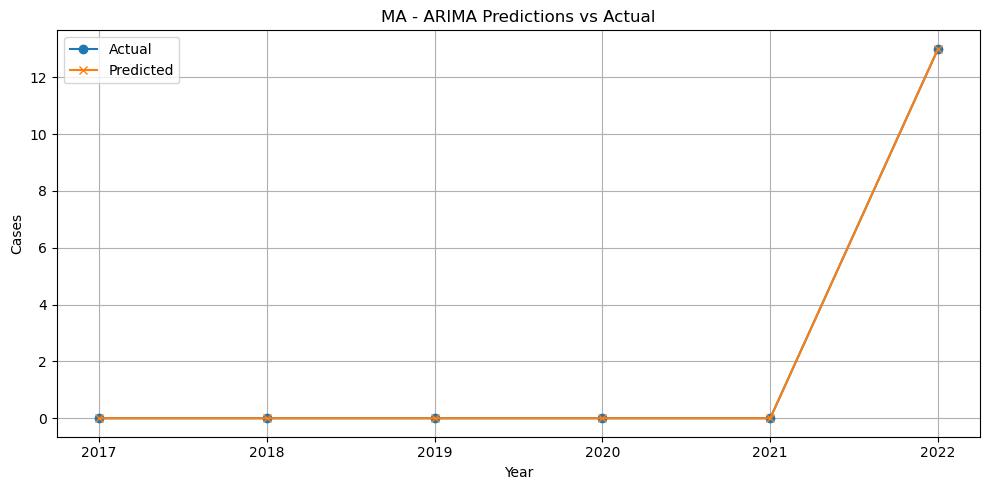

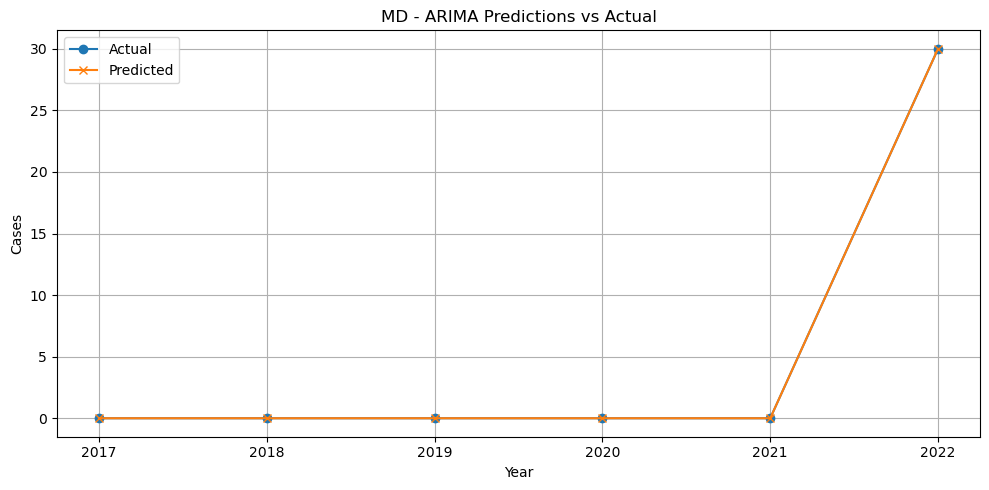

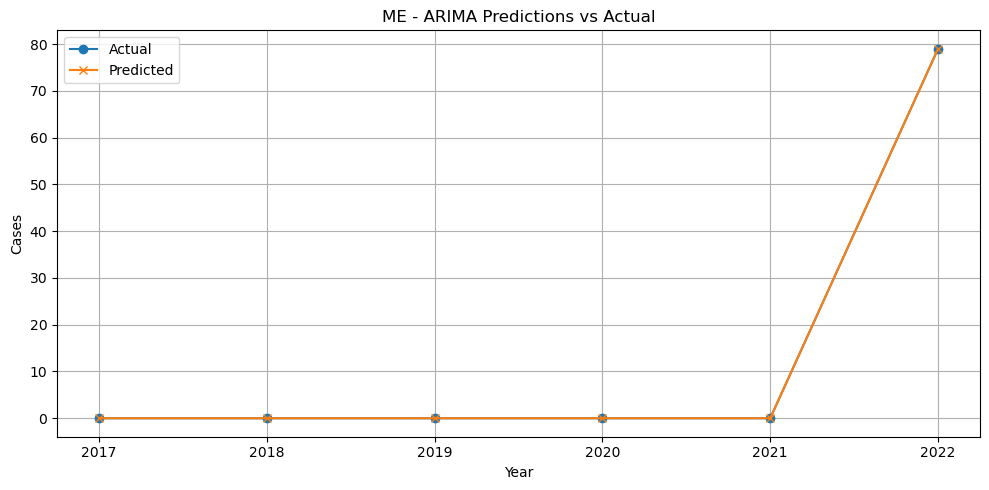

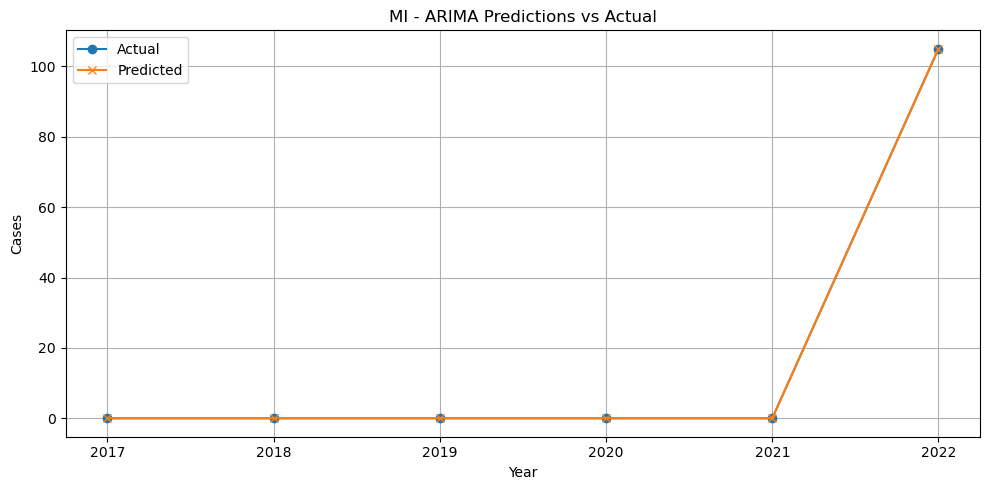

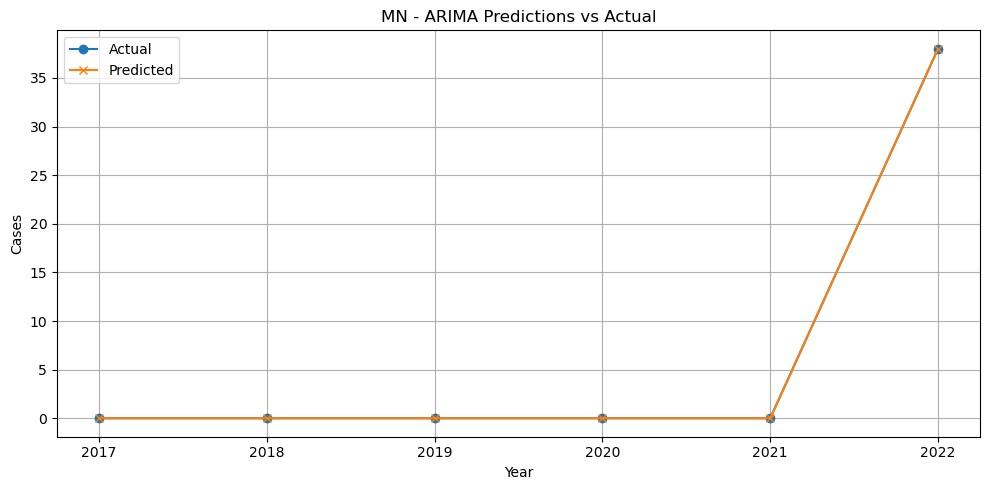

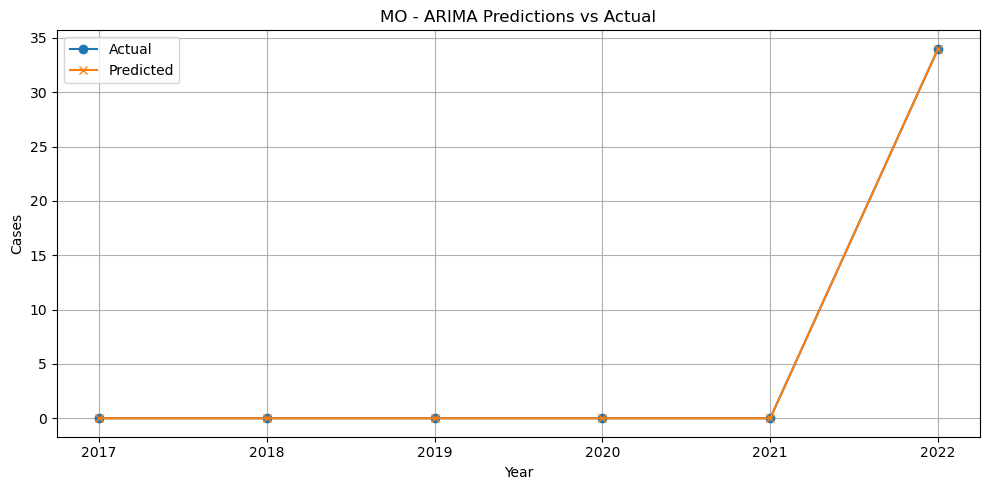

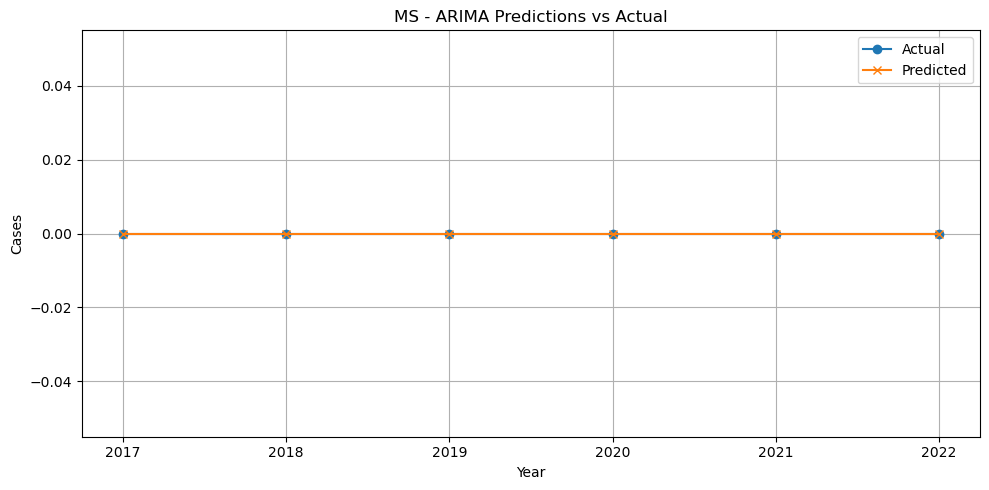

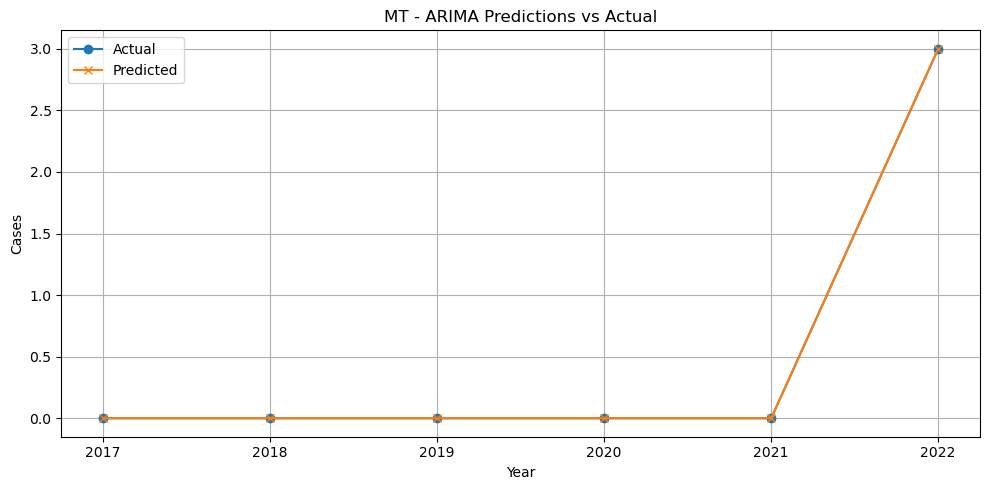

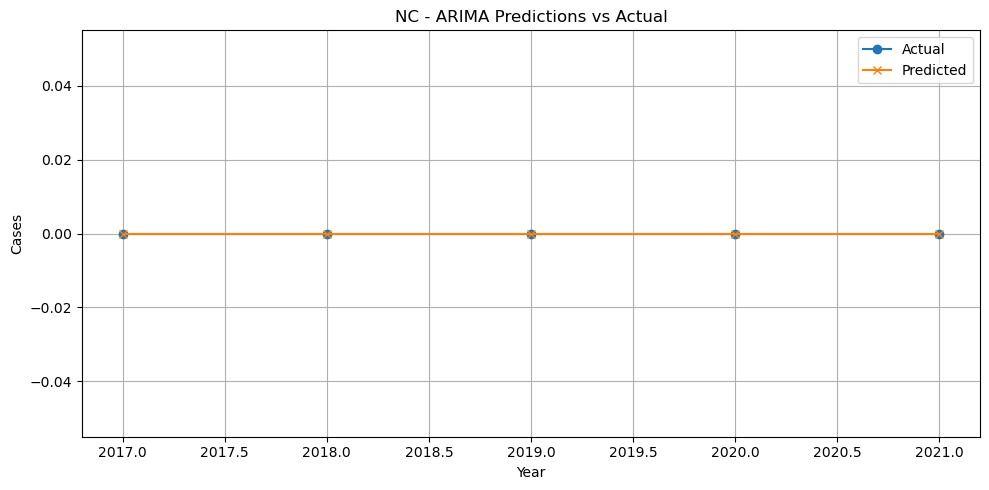

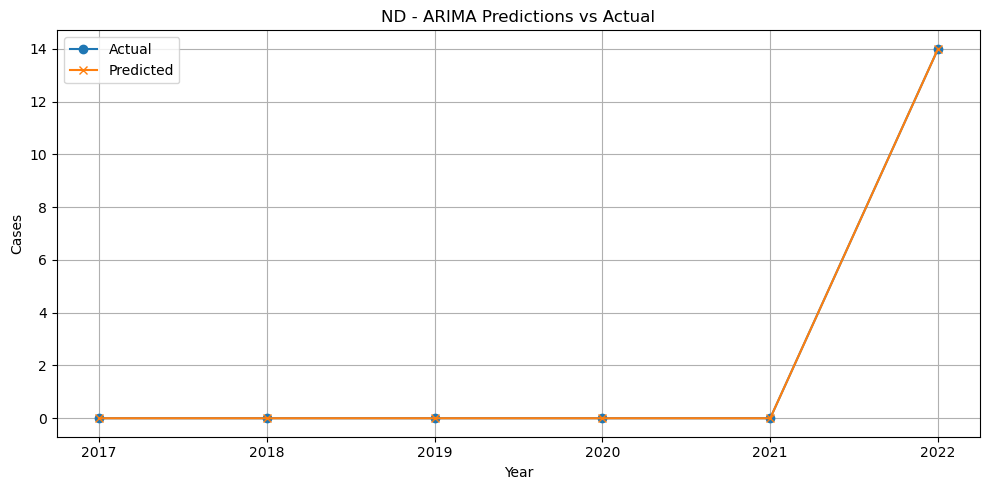

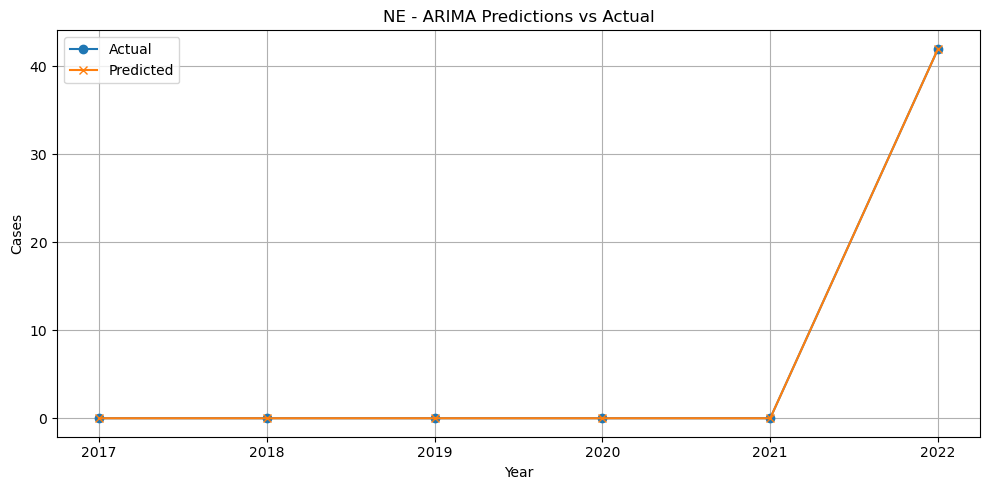

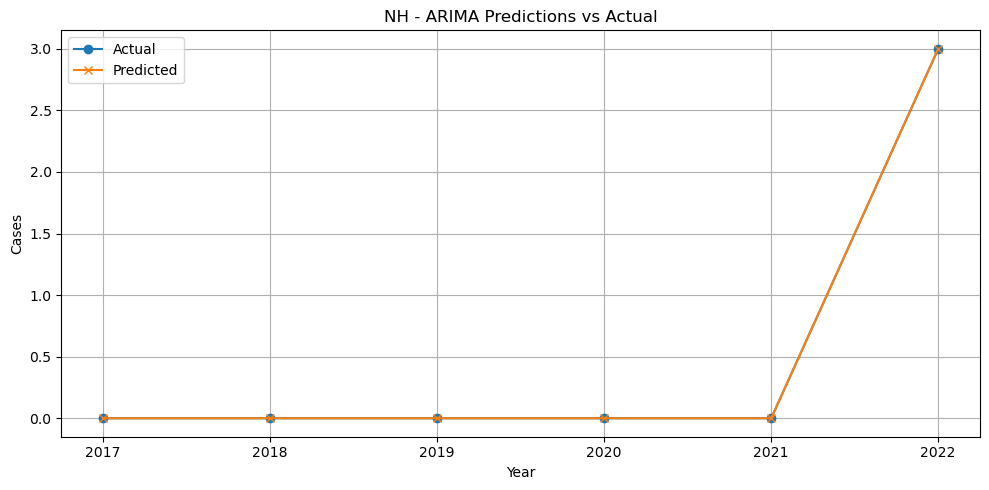

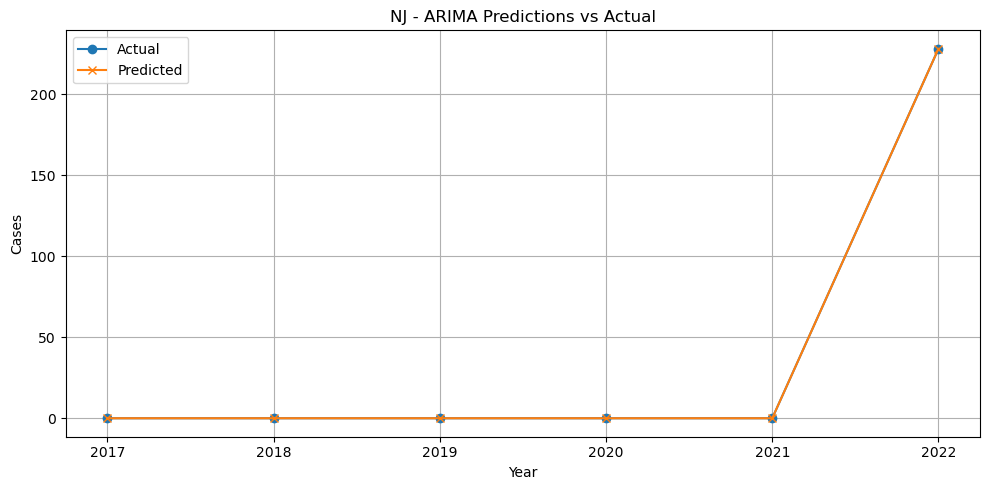

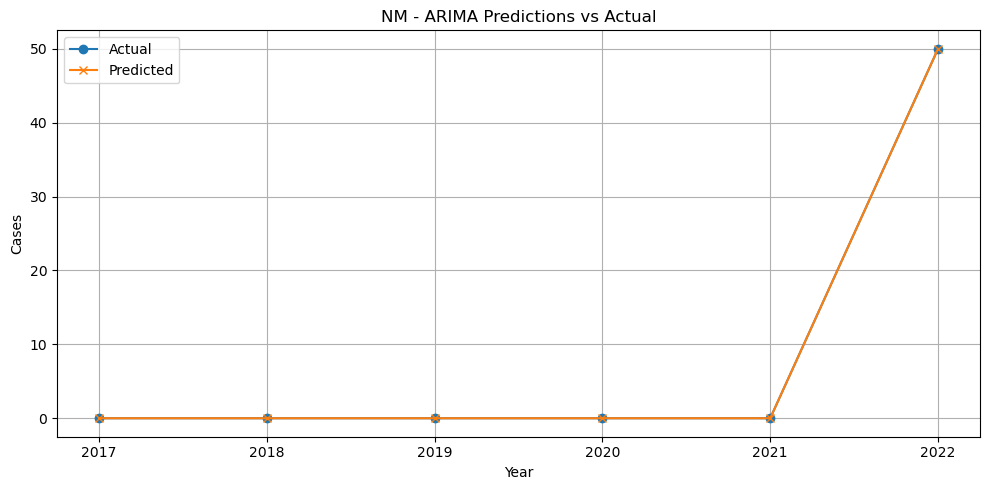

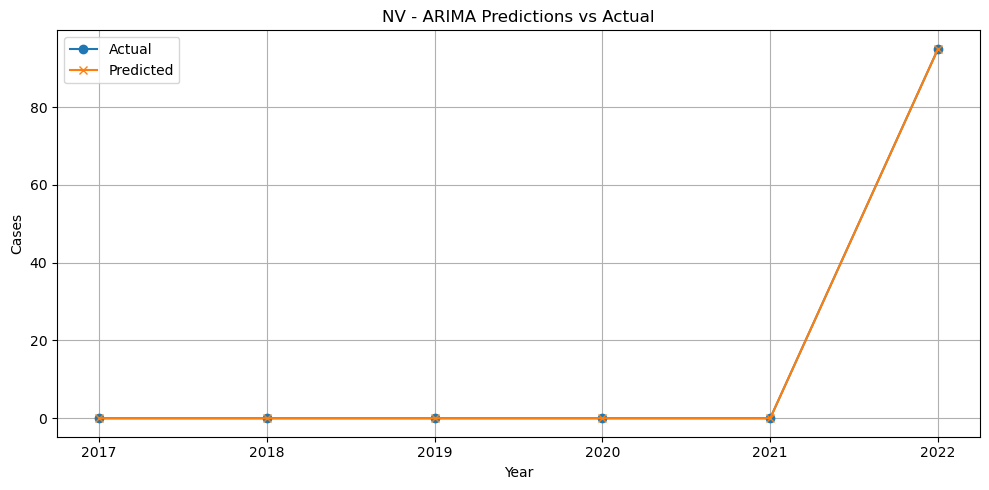

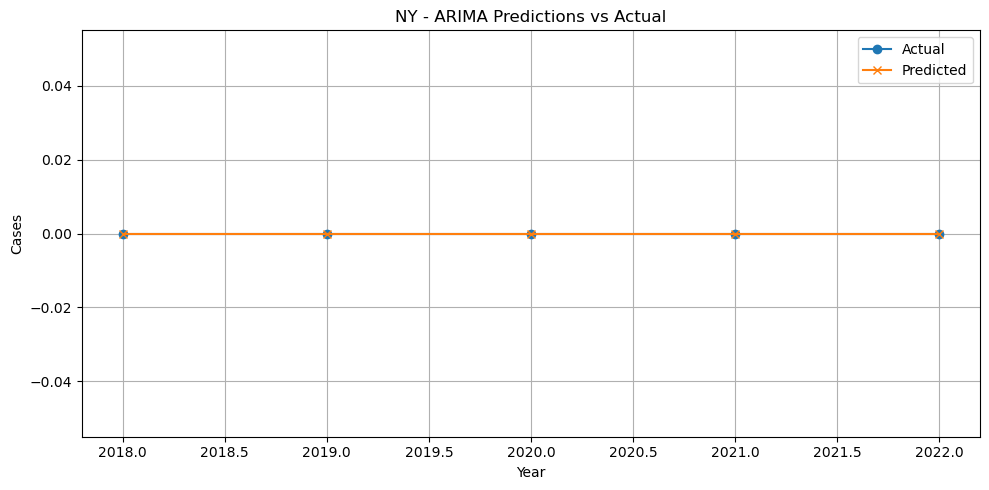

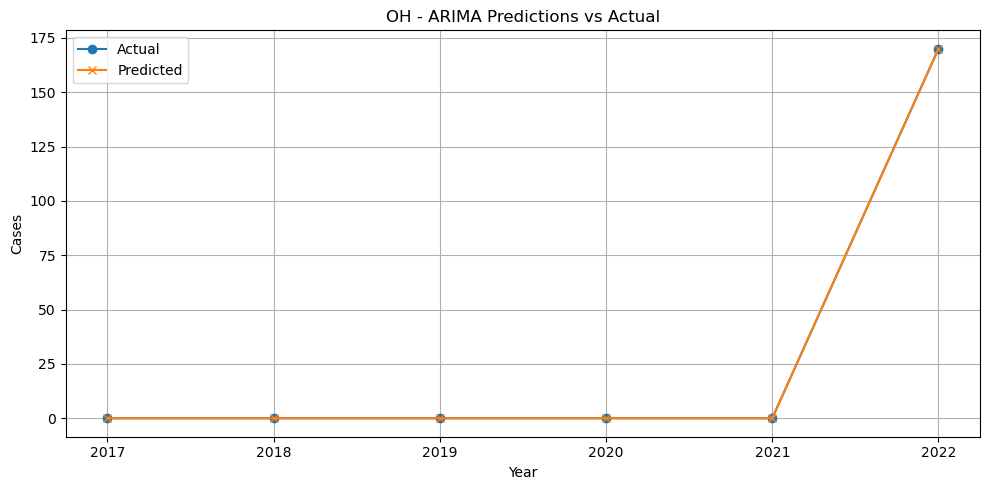

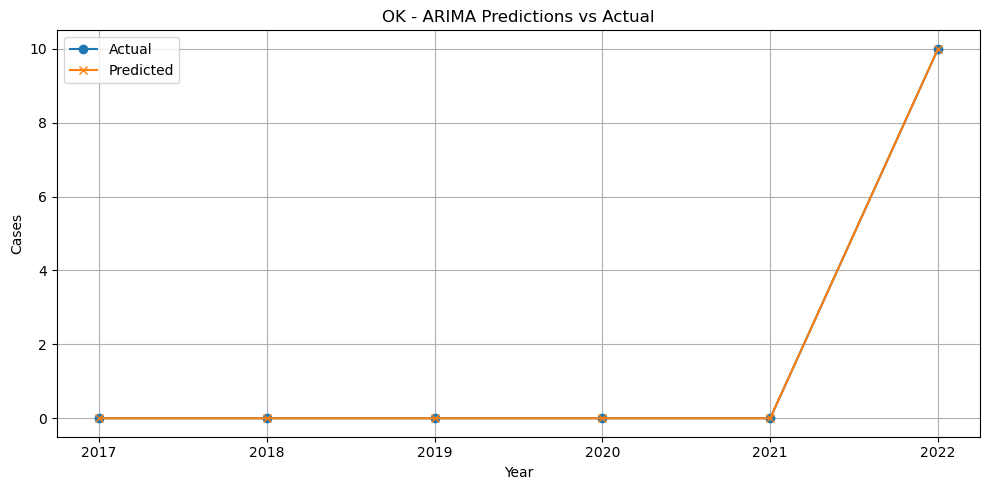

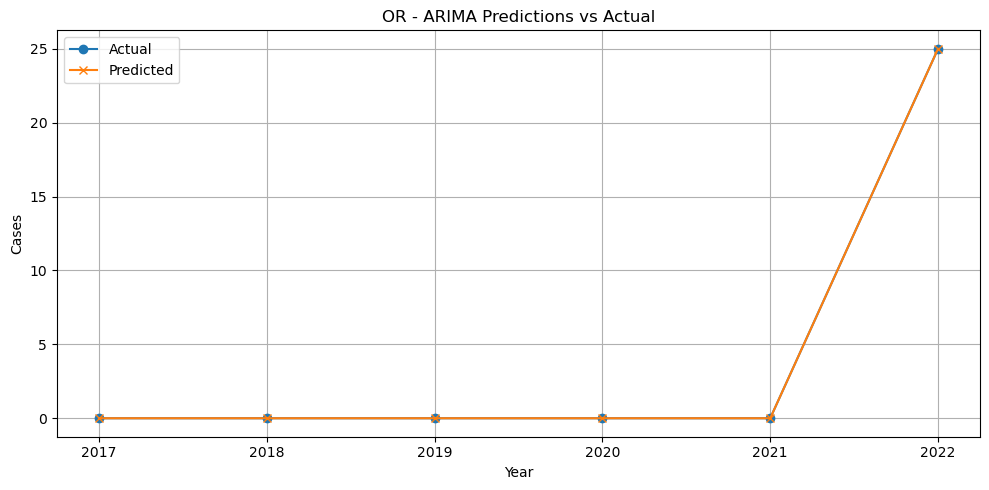

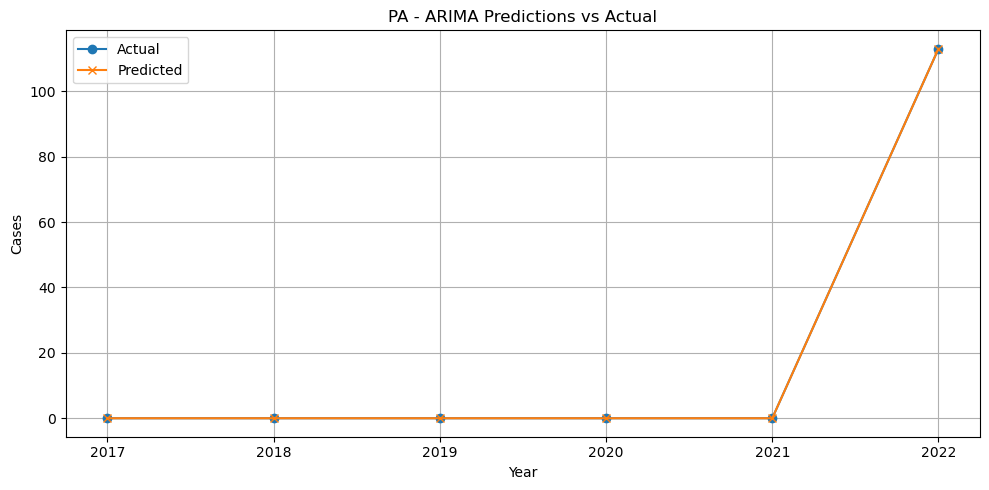

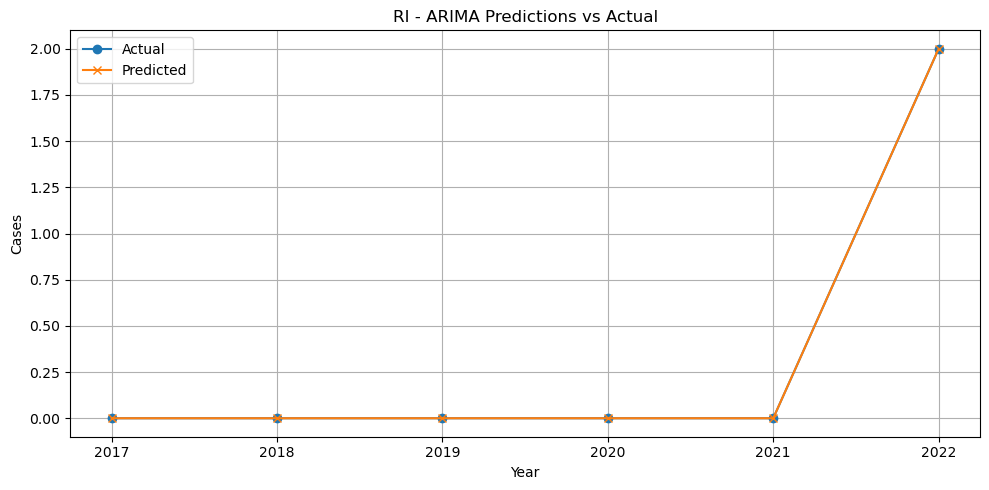

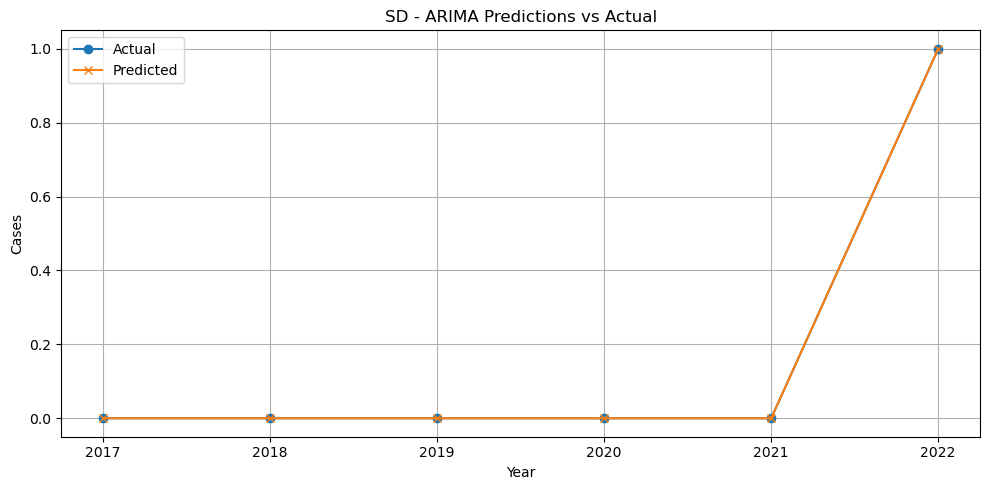

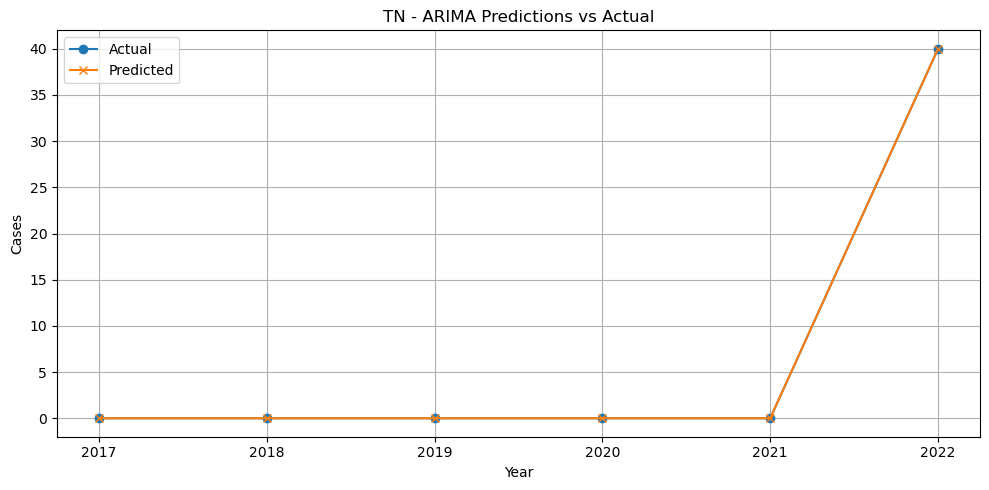

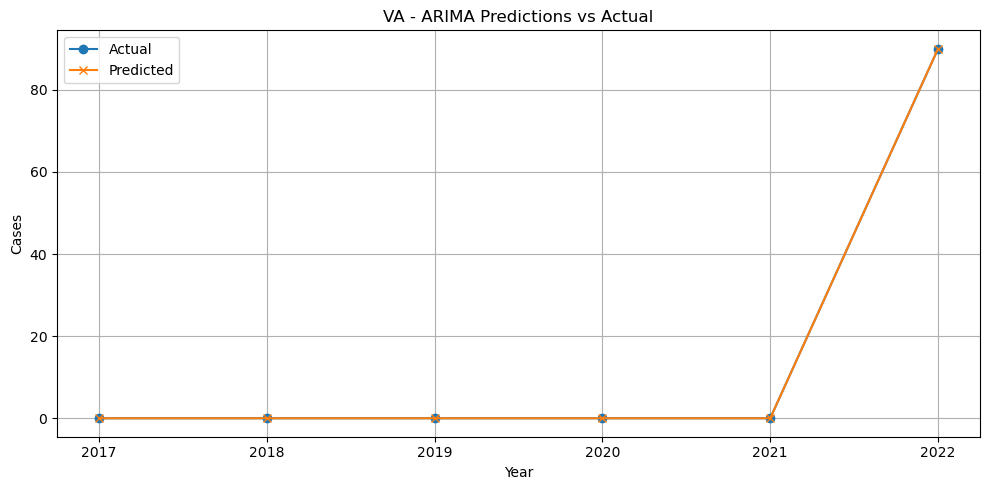

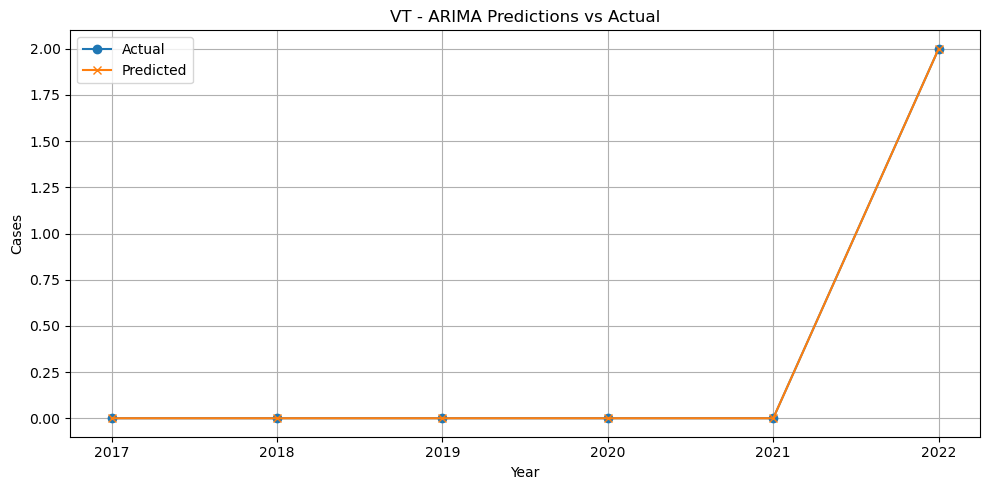

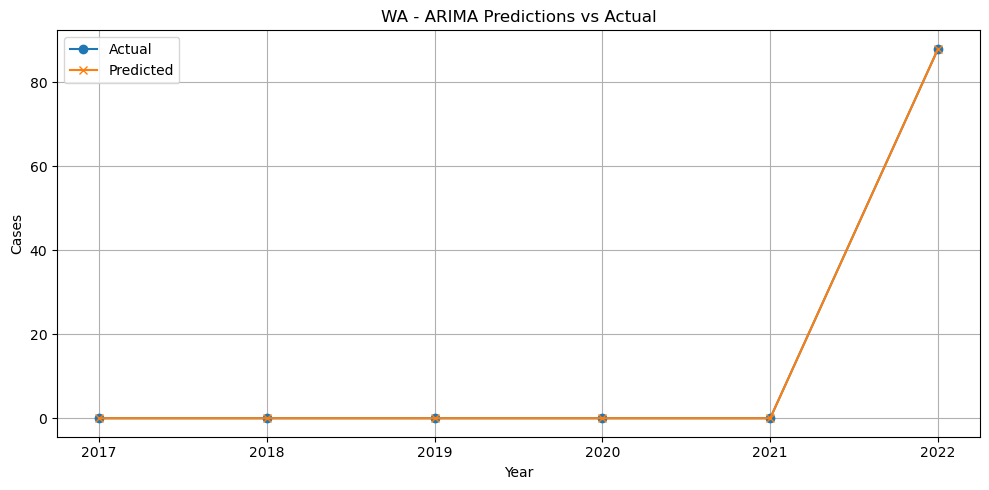

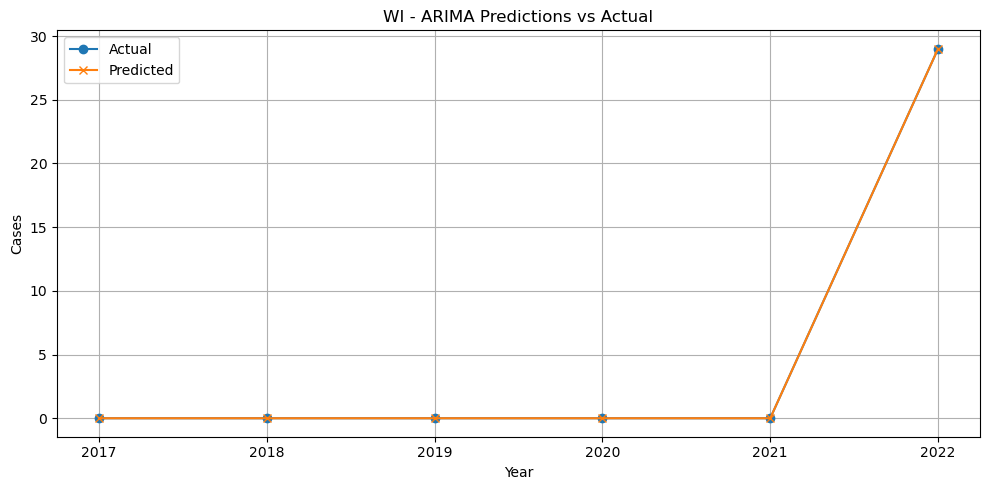

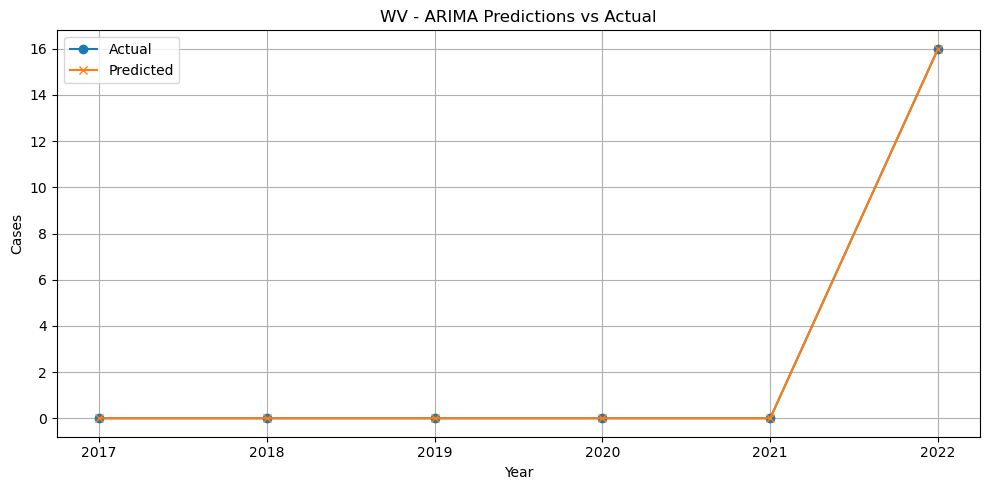

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("final_model_dataset_with_features.csv")
df = df.sort_values(["state", "year"])
df = df.dropna(subset=["cases"])

# Define exogenous variables
exog_vars = df.columns.difference(["cases", "state", "year"])

# Store metrics and predictions
results = []
predictions_plot_data = []

for state in df["state"].unique():
    state_df = df[df["state"] == state].copy()

    if len(state_df) < 5:
        continue  # Skip if not enough data

    try:
        y = state_df["cases"]
        X = state_df[exog_vars]

        # Fit ARIMA with exogenous variables
        model = ARIMA(endog=y, exog=X, order=(1, 1, 1))
        fitted = model.fit()

        # Predict (excluding first row due to differencing)
        preds = fitted.predict(start=1, end=len(y)-1, exog=X.iloc[1:], typ='levels')
        actual = y.iloc[1:]
        years = state_df["year"].iloc[1:]

        # Store for plotting
        predictions_plot_data.append(pd.DataFrame({
            "state": state,
            "year": years,
            "actual": actual,
            "predicted": preds
        }))

        # Evaluation metrics
        mae = mean_absolute_error(actual, preds)
        rmse = np.sqrt(mean_squared_error(actual, preds))
        r2 = r2_score(actual, preds)

        results.append({
            "state": state,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

    except Exception as e:
        print(f"Skipped {state} due to error: {e}")
        continue

# Metrics DataFrame
results_df = pd.DataFrame(results)

# Average metrics
average_metrics = results_df[["MAE", "RMSE", "R2"]].mean()
print("Average Metrics Across States (ARIMA):")
print(average_metrics)

# Combine all predictions
all_preds_df = pd.concat(predictions_plot_data)

# Plot actual vs predicted for each state
for state in all_preds_df["state"].unique():
    state_data = all_preds_df[all_preds_df["state"] == state]
    plt.figure(figsize=(10, 5))
    plt.plot(state_data["year"], state_data["actual"], label="Actual", marker='o')
    plt.plot(state_data["year"], state_data["predicted"], label="Predicted", marker='x')
    plt.title(f"{state} - ARIMA Predictions vs Actual")
    plt.xlabel("Year")
    plt.ylabel("Cases")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**This code fits an ARIMA model with exogenous variables (also called ARIMAX) to predict disease case counts across U.S. states. The data is first preprocessed by sorting by state and year, and rows with missing case values are removed. Exogenous variables are defined as all columns in the dataset except the target (cases), the grouping key (state), and the time variable (year).**

**For each state, if there are enough observations (at least 5), the model proceeds to fit an ARIMA(1,1,1) model using the state's time series of disease cases and associated predictors. The model then generates in-sample predictions starting from the second observation (due to differencing). These predictions are compared with actual case values using three evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). States with successful model fits have their performance metrics stored and printed at the end, sorted by RMSE to easily identify the best-performing models.**

**This approach allows for both temporal and multivariate relationships to be captured, improving predictive accuracy compared to univariate ARIMA alone. The summary output provides a way to compare prediction quality across different states.**